In [1]:
#Importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pymsaviz import MsaViz
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord


In [2]:
def GC_content(strand):
    strand = strand.upper()
    return (strand.count("G")+strand.count("C"))/len(strand) * 100

In [3]:
#Getting Chromosome Lengths From reference genome
from Bio import SeqIO 
ref = r'D:\bioinfo\refs\hg19\hg19.fasta'
chroms = SeqIO.parse(open(ref),'fasta')
c=0
chromLengths=[]
for chrom in chroms: 
    print(chrom.description)
    print(chrom.description.split(':')[-2])
    chromLengths+=[int(chrom.description.split(':')[-2])]
    c+=1
    if c==23:
        break

1 dna:chromosome chromosome:GRCh37:1:1:249250621:1
249250621
2 dna:chromosome chromosome:GRCh37:2:1:243199373:1
243199373
3 dna:chromosome chromosome:GRCh37:3:1:198022430:1
198022430
4 dna:chromosome chromosome:GRCh37:4:1:191154276:1
191154276
5 dna:chromosome chromosome:GRCh37:5:1:180915260:1
180915260
6 dna:chromosome chromosome:GRCh37:6:1:171115067:1
171115067
7 dna:chromosome chromosome:GRCh37:7:1:159138663:1
159138663
8 dna:chromosome chromosome:GRCh37:8:1:146364022:1
146364022
9 dna:chromosome chromosome:GRCh37:9:1:141213431:1
141213431
10 dna:chromosome chromosome:GRCh37:10:1:135534747:1
135534747
11 dna:chromosome chromosome:GRCh37:11:1:135006516:1
135006516
12 dna:chromosome chromosome:GRCh37:12:1:133851895:1
133851895
13 dna:chromosome chromosome:GRCh37:13:1:115169878:1
115169878
14 dna:chromosome chromosome:GRCh37:14:1:107349540:1
107349540
15 dna:chromosome chromosome:GRCh37:15:1:102531392:1
102531392
16 dna:chromosome chromosome:GRCh37:16:1:90354753:1
90354753
17 dna:chrom

#### sample_dataset

In [18]:
sample_dataset = pd.DataFrame(columns=["name","sequence","chrom","chromStart",
                                      "chromEnd","strand","mismatch",
                                      "*frequency_score"])
sample_dataset.head()

,name,sequence,chrom,chromStart,chromEnd,strand,mismatch,*frequency_score


In [7]:
bliss = pd.read_excel("BLISS.xlsx")

bliss =bliss.rename(columns={"Target":"name","On-/off-target (name) (OT = off-target)":"on_off","Unique DSB ends per 10^5 reads (DSB score)":"dsb_score",
            "Standard deviation of DSB score":"std_dsb_score","Matched genomic target":"sequence","On-/off-target coord":"coordinate",
                            }
            )
bliss.drop(columns=["Forward","Reverse"],axis=1,inplace=True)
bliss.columns = bliss.columns.str.lower()
bliss.columns = bliss.columns.str.strip()

bliss.columns = bliss.columns.str.replace(' ', '_')
bliss[['chrom', 'chromStart','chromEnd']] = bliss['coordinate'].str.extract(r"(chr.*):(\d*)-(\d*)",expand=True)
bliss['on_off']=bliss['on_off'].apply(lambda x: x.split("(")[0].strip(" "))
bliss.loc[bliss["name"]=="VEGFA","name"]="VEGFA_site3"
bliss['mismatch'] = bliss["sequence"].apply(lambda x :  sum(map(x.count,["a","c","g","t"])))
bliss["strand"]=pd.NA
bliss = bliss[["name","sequence","chrom","chromStart","chromEnd","strand",
               "mismatch","dsb_score","guide_homology_score","guideseq"]]
bliss["target_length"]=bliss["sequence"].apply(lambda x : len(x))

bliss

,name,sequence,chrom,chromStart,chromEnd,strand,mismatch,dsb_score,guide_homology_score,guideseq,target_length
0,EMX1,GAGTCCGAGCAGAAGAAGAAGGG,chr2,73160973,73161010,NaN,0,14.883283,60,1,23
1,EMX1,GAGTtaGAGCAGAAGAAGAAAGG,chr5,45359051,45359082,NaN,2,3.843422,52,1,23
2,EMX1,GAGTCtaAGCAGAAGAAGAAGAG,chr15,44109742,44109763,NaN,2,3.478468,52,1,23
3,EMX1,GAGTCCtAGCAGgAGAAGAAGAG,chr8,128801235,128801269,NaN,2,1.744937,52,1,23
4,EMX1,GAGgCCGAGCAGAAGAAagACGG,chr2,219845069,219845072,NaN,3,1.003624,48,1,23
...,...,...,...,...,...,...,...,...,...,...,...
56,VEGFA_site3,GGTGtGTGtGTGTGTG-GTGGGG,chr9,95966358,95966408,NaN,2,0.051478,44,0,23
57,VEGFA_site3,GGTGAGgGcGTGTcTGgGTGAGG,chr12,132881700,132881718,NaN,4,0.041182,44,0,23
58,VEGFA_site3,GTGAGaaAGTGTGTGCaTGCGG,chr2,18696223,18696224,NaN,3,0.041182,44,1,22
59,VEGFA_site3,GTGtGTGtGTGTGTGtGTGTGG,chr15,22512148,22512163,NaN,3,0.041182,45,0,22


In [4]:
guideseq= pd.read_excel('GUIDEseq.xlsx')
guideseq.columns = [x.lower() for x in guideseq.columns]
guideseq.columns = [x.replace(' ','_') for x in guideseq.columns]
guideseq=guideseq.rename(columns={"#chromosome":"chrom","start":"chromStart",
                     "end":"chromEnd","name":"coordinate",
                     "targetsite":"name","offtarget_sequence":"sequence",
                    "mismatch_total":"mismatch"})
guideseq= guideseq[guideseq["name"].isin(["VEGFA_site3","EMX1"])]
guideseq = guideseq[["name","sequence","chrom","chromStart","chromEnd","strand",
               "mismatch","guide-seq_reads"]]
guideseq["target_length"]=guideseq["sequence"].apply(lambda x : len(x))

guideseq.head()

,name,sequence,chrom,chromStart,chromEnd,strand,mismatch,guide-seq_reads,target_length
174,VEGFA_site3,AGTGAGTGAGTGTGTGTGTGGGG,chr14,65569152,65569175,-,2,3125,23
175,VEGFA_site3,AGAGAGTGAGTGTGTGCATGAGG,chr5,89440962,89440985,-,3,2559,23
176,VEGFA_site3,GGTGAGTGAGTGTGTGCGTGTGG,chr6,43737453,43737476,+,0,2440,23
177,VEGFA_site3,TGTGGGTGAGTGTGTGCGTGAGG,chr5,115434658,115434681,+,2,2200,23
178,VEGFA_site3,GCTGAGTGAGTGTATGCGTGTGG,chr22,37662817,37662840,-,2,1997,23


## Inconsistency between genomic coordination of the same target sites between guideseq and bliss
probably due to different pipelines? / genome version? (USCC hg19 was reported to be used in both cases)

* In certain cases, off-target sites with DNA bulges may also be interpreted as sequences having various base mismatches with guide sequence and/or PAM  [CRISPR/Cas9 systems have off-target activity with insertions or deletions between target DNA and guide RNA sequences](https://academic.oup.com/nar/article/42/11/7473/1454761?login=false)

In [8]:
def adjust_seq(df):
    filter=guideseq.loc[(guideseq["chrom"]==df["chrom"])&(guideseq["name"]==df["name"])]
    if df["guideseq"]==1:

        for chromStart in filter["chromStart"]:
            bliss_coordinate= str(df["chromStart"])
            guideseq_coordinate = str(chromStart)
            print(f"bliss:{bliss_coordinate}-{bliss_coordinate[:-3]}")
            print(f"guideseq:{guideseq_coordinate}-{guideseq_coordinate[:-3]}")
            
            if bliss_coordinate[:-3]==guideseq_coordinate[:-3]:
                display((filter.loc[(filter["chromStart"]==chromStart)]).iloc[0])
                return filter.loc[(filter["chromStart"]==chromStart)].iloc[0]
        return df
    else:
        return df



In [9]:
bliss["chromStart"]= bliss.apply(lambda row: adjust_seq(row)["chromStart"],axis=1)
bliss["chromEnd"]= bliss.apply(lambda row: adjust_seq(row)["chromEnd"],axis=1)
bliss["sequence"]= bliss.apply(lambda row: adjust_seq(row)["sequence"],axis=1)
bliss["mismatch"]= bliss.apply(lambda row: adjust_seq(row)["mismatch"],axis=1)
bliss["strand"]= bliss.apply(lambda row: adjust_seq(row)["strand"],axis=1)
bliss["target_length"]= bliss.apply(lambda row: adjust_seq(row)["target_length"],axis=1)


bliss:73160973-73160
guideseq:73160981-73160


name                                  EMX1
sequence           GAGTCCGAGCAGAAGAAGAAGGG
chrom                                 chr2
chromStart                        73160981
chromEnd                          73161004
strand                                   +
mismatch                                 0
guide-seq_reads                       4521
target_length                           23
Name: 234, dtype: object

bliss:45359051-45359
guideseq:45359060-45359


name                                  EMX1
sequence           GAGTTAGAGCAGAAGAAGAAAGG
chrom                                 chr5
chromStart                        45359060
chromEnd                          45359083
strand                                   -
mismatch                                 2
guide-seq_reads                       3123
target_length                           23
Name: 235, dtype: object

bliss:44109742-44109
guideseq:44109746-44109


name                                  EMX1
sequence           GAGTCTAAGCAGAAGAAGAAGAG
chrom                                chr15
chromStart                        44109746
chromEnd                          44109769
strand                                   +
mismatch                                 3
guide-seq_reads                       1445
target_length                           23
Name: 236, dtype: object

bliss:128801235-128801
guideseq:128801241-128801


name                                  EMX1
sequence           GAGTCCTAGCAGGAGAAGAAGAG
chrom                                 chr8
chromStart                       128801241
chromEnd                         128801264
strand                                   +
mismatch                                 3
guide-seq_reads                        390
target_length                           23
Name: 238, dtype: object

bliss:219845069-219845
guideseq:73160981-73160
bliss:219845069-219845
guideseq:219845055-219845


name                                  EMX1
sequence           GAGGCCGAGCAGAAGAAAGACGG
chrom                                 chr2
chromStart                       219845055
chromEnd                         219845078
strand                                   +
mismatch                                 3
guide-seq_reads                        700
target_length                           23
Name: 237, dtype: object

bliss:9227160-9227
guideseq:45359060-45359
bliss:9227160-9227
guideseq:9227145-9227


name                                  EMX1
sequence           AAGTCTGAGCACAAGAAGAATGG
chrom                                 chr5
chromStart                         9227145
chromEnd                           9227168
strand                                   +
mismatch                                 3
guide-seq_reads                        258
target_length                           23
Name: 239, dtype: object

bliss:9118797-9118
guideseq:9118792-9118


name                                  EMX1
sequence           ACGTCTGAGCAGAAGAAGAATGG
chrom                                 chr6
chromStart                         9118792
chromEnd                           9118815
strand                                   -
mismatch                                 3
guide-seq_reads                         38
target_length                           23
Name: 244, dtype: object

bliss:23720617-23720
guideseq:23720611-23720


name                                  EMX1
sequence           AAGTCCGAGGAGAGGAAGAAAGG
chrom                                 chr1
chromStart                        23720611
chromEnd                          23720634
strand                                   -
mismatch                                 3
guide-seq_reads                        102
target_length                           23
Name: 242, dtype: object

bliss:100292453-100292
guideseq:44109746-44109
bliss:100292453-100292
guideseq:100292461-100292


name                                  EMX1
sequence           AAGTCCCGGCAGAGGAAGAAGGG
chrom                                chr15
chromStart                       100292461
chromEnd                         100292484
strand                                   +
mismatch                                 4
guide-seq_reads                          6
target_length                           23
Name: 246, dtype: object

bliss:43737464-43737
guideseq:43737453-43737


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGCGTGTGG
chrom                                 chr6
chromStart                        43737453
chromEnd                          43737476
strand                                   +
mismatch                                 0
guide-seq_reads                       2440
target_length                           23
Name: 176, dtype: object

bliss:115434642-115434
guideseq:89440962-89440
bliss:115434642-115434
guideseq:115434658-115434


name                           VEGFA_site3
sequence           TGTGGGTGAGTGTGTGCGTGAGG
chrom                                 chr5
chromStart                       115434658
chromEnd                         115434681
strand                                   +
mismatch                                 2
guide-seq_reads                       2200
target_length                           23
Name: 177, dtype: object

bliss:89440967-89440
guideseq:89440962-89440


name                           VEGFA_site3
sequence           AGAGAGTGAGTGTGTGCATGAGG
chrom                                 chr5
chromStart                        89440962
chromEnd                          89440985
strand                                   -
mismatch                                 3
guide-seq_reads                       2559
target_length                           23
Name: 175, dtype: object

bliss:74353482-74353
guideseq:65569152-65569
bliss:74353482-74353
guideseq:62078766-62078
bliss:74353482-74353
guideseq:74353479-74353


name                           VEGFA_site3
sequence           AGCGAGTGGGTGTGTGCGTGGGG
chrom                                chr14
chromStart                        74353479
chromEnd                          74353502
strand                                   +
mismatch                                 3
guide-seq_reads                        790
target_length                           23
Name: 184, dtype: object

bliss:23824539-23824
guideseq:23824547-23824


name                           VEGFA_site3
sequence           TGTGGGTGAGTGTGTGCGTGAGA
chrom                                 chr9
chromStart                        23824547
chromEnd                          23824570
strand                                   -
mismatch                                 3
guide-seq_reads                        643
target_length                           23
Name: 186, dtype: object

bliss:65569145-65569
guideseq:65569152-65569


name                           VEGFA_site3
sequence           AGTGAGTGAGTGTGTGTGTGGGG
chrom                                chr14
chromStart                        65569152
chromEnd                          65569175
strand                                   -
mismatch                                 2
guide-seq_reads                       3125
target_length                           23
Name: 174, dtype: object

bliss:106029011-106029
guideseq:65569152-65569
bliss:106029011-106029
guideseq:62078766-62078
bliss:106029011-106029
guideseq:74353479-74353
bliss:106029011-106029
guideseq:106029014-106029


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGTGTGAGG
chrom                                chr14
chromStart                       106029014
chromEnd                         106029037
strand                                   +
mismatch                                 1
guide-seq_reads                        199
target_length                           23
Name: 188, dtype: object

bliss:98760564-98760
guideseq:98760581-98760


name                           VEGFA_site3
sequence           GTTGAGTGAATGTGTGCGTGAGG
chrom                                chr10
chromStart                        98760581
chromEnd                          98760604
strand                                   -
mismatch                                 2
guide-seq_reads                       1437
target_length                           23
Name: 180, dtype: object

bliss:68851136-68851
guideseq:68851125-68851


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGCGGGTGG
chrom                                chr11
chromStart                        68851125
chromEnd                          68851148
strand                                   +
mismatch                                 1
guide-seq_reads                       1535
target_length                           23
Name: 179, dtype: object

bliss:193993881-193993
guideseq:193993877-193993


name                           VEGFA_site3
sequence           AGTGAATGAGTGTGTGTGTGTGG
chrom                                 chr3
chromStart                       193993877
chromEnd                         193993900
strand                                   -
mismatch                                 3
guide-seq_reads                       1315
target_length                           23
Name: 181, dtype: object

bliss:130228343-130228
guideseq:98760581-98760
bliss:130228343-130228
guideseq:5749650-5749
bliss:130228343-130228
guideseq:130228336-130228


name                           VEGFA_site3
sequence           AGGGAGTGACTGTGTGCGTGTGG
chrom                                chr10
chromStart                       130228336
chromEnd                         130228359
strand                                   +
mismatch                                 3
guide-seq_reads                         24
target_length                           23
Name: 210, dtype: object

bliss:50724390-50724
guideseq:20178277-20178
bliss:50724390-50724
guideseq:50724387-50724


name                           VEGFA_site3
sequence           CGTGAGTGAGTGTGTACCTGGGG
chrom                                chr20
chromStart                        50724387
chromEnd                          50724410
strand                                   +
mismatch                                 3
guide-seq_reads                         19
target_length                           23
Name: 213, dtype: object

bliss:177463424-177463
guideseq:73317043-73317
bliss:177463424-177463
guideseq:177463419-177463


name                           VEGFA_site3
sequence           GGTGAGTGTGTGTGTGCATGTGG
chrom                                 chr2
chromStart                       177463419
chromEnd                         177463442
strand                                   -
mismatch                                 2
guide-seq_reads                         33
target_length                           23
Name: 205, dtype: object

bliss:84032633-84032
guideseq:80016313-80016
bliss:84032633-84032
guideseq:84032639-84032


name                           VEGFA_site3
sequence           GGTGAATGAGTGTGTGCTCTGGG
chrom                                chr16
chromStart                        84032639
chromEnd                          84032662
strand                                   -
mismatch                                 4
guide-seq_reads                         26
target_length                           23
Name: 209, dtype: object

bliss:6109029-6109
guideseq:40561860-40561
bliss:6109029-6109
guideseq:47732485-47732
bliss:6109029-6109
guideseq:1716774-1716
bliss:6109029-6109
guideseq:17594216-17594
bliss:6109029-6109
guideseq:6109015-6109


name                           VEGFA_site3
sequence           TGTGAGTGAGTGTGTGTGTGTGA
chrom                                chr19
chromStart                         6109015
chromEnd                           6109038
strand                                   +
mismatch                                 3
guide-seq_reads                          6
target_length                           23
Name: 226, dtype: object

bliss:20178282-20178
guideseq:20178277-20178


name                           VEGFA_site3
sequence           AGTGTGTGAGTGTGTGCGTGTGG
chrom                                chr20
chromStart                        20178277
chromEnd                          20178300
strand                                   -
mismatch                                 2
guide-seq_reads                        686
target_length                           23
Name: 185, dtype: object

bliss:48997804-48997
guideseq:22932496-22932
bliss:48997804-48997
guideseq:48997788-48997


name                           VEGFA_site3
sequence           GTAGAGTGAGTGTGTGTGTGTGG
chrom                                 chr8
chromStart                        48997788
chromEnd                          48997811
strand                                   +
mismatch                                 3
guide-seq_reads                         82
target_length                           23
Name: 197, dtype: object

bliss:74103173-74103
guideseq:74103157-74103


name                           VEGFA_site3
sequence           GGTGAGTAAGTGTGAGCGTAAGG
chrom                                chr18
chromStart                        74103157
chromEnd                          74103180
strand                                   +
mismatch                                 3
guide-seq_reads                         33
target_length                           23
Name: 206, dtype: object

bliss:62078772-62078
guideseq:65569152-65569
bliss:62078772-62078
guideseq:62078766-62078


name                           VEGFA_site3
sequence           TGTGAGTAAGTGTGTGTGTGTGG
chrom                                chr14
chromStart                        62078766
chromEnd                          62078789
strand                                   -
mismatch                                 3
guide-seq_reads                       1170
target_length                           23
Name: 182, dtype: object

bliss:40561858-40561
guideseq:40561860-40561


name                           VEGFA_site3
sequence           ACTGTGTGAGTGTGTGCGTGAGG
chrom                                chr19
chromStart                        40561860
chromEnd                          40561883
strand                                   -
mismatch                                 3
guide-seq_reads                        796
target_length                           23
Name: 183, dtype: object

bliss:144458289-144458
guideseq:43737453-43737
bliss:144458289-144458
guideseq:157078320-157078
bliss:144458289-144458
guideseq:144458273-144458


name                           VEGFA_site3
sequence           AGGGAGTGAGTGTGAGAGTGCGG
chrom                                 chr6
chromStart                       144458273
chromEnd                         144458296
strand                                   +
mismatch                                 4
guide-seq_reads                          4
target_length                           23
Name: 229, dtype: object

bliss:22932494-22932
guideseq:22932496-22932


name                           VEGFA_site3
sequence           TGTGAGTGAGTGTGTGTGTGTGA
chrom                                 chr8
chromStart                        22932496
chromEnd                          22932519
strand                                   -
mismatch                                 3
guide-seq_reads                        111
target_length                           23
Name: 193, dtype: object

bliss:47732491-47732
guideseq:40561860-40561
bliss:47732491-47732
guideseq:47732485-47732


name                           VEGFA_site3
sequence           CTGGAGTGAGTGTGTGTGTGTGG
chrom                                chr19
chromStart                        47732485
chromEnd                          47732508
strand                                   -
mismatch                                 4
guide-seq_reads                        193
target_length                           23
Name: 189, dtype: object

bliss:79178521-79178
guideseq:68851125-68851
bliss:79178521-79178
guideseq:79178505-79178


name                           VEGFA_site3
sequence           AGTGAGTGAGTGAGTGAGTGGGG
chrom                                chr11
chromStart                        79178505
chromEnd                          79178528
strand                                   +
mismatch                                 3
guide-seq_reads                         32
target_length                           23
Name: 207, dtype: object

bliss:230506239-230506
guideseq:73317043-73317
bliss:230506239-230506
guideseq:177463419-177463
bliss:230506239-230506
guideseq:230506234-230506


name                           VEGFA_site3
sequence           GGTGAGCAAGTGTGTGTGTGTGG
chrom                                 chr2
chromStart                       230506234
chromEnd                         230506257
strand                                   -
mismatch                                 3
guide-seq_reads                         20
target_length                           23
Name: 212, dtype: object

bliss:71632808-71632
guideseq:193993877-193993
bliss:71632808-71632
guideseq:71632802-71632


name                           VEGFA_site3
sequence           CGCGAGTGAGTGTGTGCGCGGGG
chrom                                 chr3
chromStart                        71632802
chromEnd                          71632825
strand                                   -
mismatch                                 3
guide-seq_reads                        215
target_length                           23
Name: 187, dtype: object

bliss:157078325-157078
guideseq:43737453-43737
bliss:157078325-157078
guideseq:157078320-157078


name                           VEGFA_site3
sequence           GATGAGTGAGTGAGTGAGTGGGG
chrom                                 chr6
chromStart                       157078320
chromEnd                         157078343
strand                                   -
mismatch                                 3
guide-seq_reads                         37
target_length                           23
Name: 202, dtype: object

bliss:47690893-47690
guideseq:48305031-48305
bliss:47690893-47690
guideseq:181557186-181557
bliss:47690893-47690
guideseq:32738746-32738
bliss:47690893-47690
guideseq:47690887-47690


name                           VEGFA_site3
sequence           TGTGAGAGAGAGTGTGCGTGTGG
chrom                                 chr1
chromStart                        47690887
chromEnd                          47690910
strand                                   -
mismatch                                 3
guide-seq_reads                          3
target_length                           23
Name: 233, dtype: object

bliss:1716790-1716
guideseq:40561860-40561
bliss:1716790-1716
guideseq:47732485-47732
bliss:1716790-1716
guideseq:1716774-1716


name                           VEGFA_site3
sequence           CATGAGTGAGTGTGTGGGTGGGG
chrom                                chr19
chromStart                         1716774
chromEnd                           1716797
strand                                   +
mismatch                                 3
guide-seq_reads                         45
target_length                           23
Name: 200, dtype: object

bliss:12264611-12264
guideseq:80016313-80016
bliss:12264611-12264
guideseq:84032639-84032
bliss:12264611-12264
guideseq:73585908-73585
bliss:12264611-12264
guideseq:74898113-74898
bliss:12264611-12264
guideseq:12264595-12264


name                           VEGFA_site3
sequence           AGTGAGTGAGTGTGTGTGTGTGA
chrom                                chr16
chromStart                        12264595
chromEnd                          12264618
strand                                   +
mismatch                                 3
guide-seq_reads                          6
target_length                           23
Name: 225, dtype: object

bliss:18696223-18696
guideseq:73317043-73317
bliss:18696223-18696
guideseq:177463419-177463
bliss:18696223-18696
guideseq:230506234-230506
bliss:18696223-18696
guideseq:18696207-18696


name                           VEGFA_site3
sequence           AGTGAGAAAGTGTGTGCATGCGG
chrom                                 chr2
chromStart                        18696207
chromEnd                          18696230
strand                                   +
mismatch                                 4
guide-seq_reads                          9
target_length                           23
Name: 223, dtype: object

bliss:73160981-73160
guideseq:73160981-73160


name                                  EMX1
sequence           GAGTCCGAGCAGAAGAAGAAGGG
chrom                                 chr2
chromStart                        73160981
chromEnd                          73161004
strand                                   +
mismatch                                 0
guide-seq_reads                       4521
target_length                           23
Name: 234, dtype: object

bliss:45359060-45359
guideseq:45359060-45359


name                                  EMX1
sequence           GAGTTAGAGCAGAAGAAGAAAGG
chrom                                 chr5
chromStart                        45359060
chromEnd                          45359083
strand                                   -
mismatch                                 2
guide-seq_reads                       3123
target_length                           23
Name: 235, dtype: object

bliss:44109746-44109
guideseq:44109746-44109


name                                  EMX1
sequence           GAGTCTAAGCAGAAGAAGAAGAG
chrom                                chr15
chromStart                        44109746
chromEnd                          44109769
strand                                   +
mismatch                                 3
guide-seq_reads                       1445
target_length                           23
Name: 236, dtype: object

bliss:128801241-128801
guideseq:128801241-128801


name                                  EMX1
sequence           GAGTCCTAGCAGGAGAAGAAGAG
chrom                                 chr8
chromStart                       128801241
chromEnd                         128801264
strand                                   +
mismatch                                 3
guide-seq_reads                        390
target_length                           23
Name: 238, dtype: object

bliss:219845055-219845
guideseq:73160981-73160
bliss:219845055-219845
guideseq:219845055-219845


name                                  EMX1
sequence           GAGGCCGAGCAGAAGAAAGACGG
chrom                                 chr2
chromStart                       219845055
chromEnd                         219845078
strand                                   +
mismatch                                 3
guide-seq_reads                        700
target_length                           23
Name: 237, dtype: object

bliss:9227145-9227
guideseq:45359060-45359
bliss:9227145-9227
guideseq:9227145-9227


name                                  EMX1
sequence           AAGTCTGAGCACAAGAAGAATGG
chrom                                 chr5
chromStart                         9227145
chromEnd                           9227168
strand                                   +
mismatch                                 3
guide-seq_reads                        258
target_length                           23
Name: 239, dtype: object

bliss:9118792-9118
guideseq:9118792-9118


name                                  EMX1
sequence           ACGTCTGAGCAGAAGAAGAATGG
chrom                                 chr6
chromStart                         9118792
chromEnd                           9118815
strand                                   -
mismatch                                 3
guide-seq_reads                         38
target_length                           23
Name: 244, dtype: object

bliss:23720611-23720
guideseq:23720611-23720


name                                  EMX1
sequence           AAGTCCGAGGAGAGGAAGAAAGG
chrom                                 chr1
chromStart                        23720611
chromEnd                          23720634
strand                                   -
mismatch                                 3
guide-seq_reads                        102
target_length                           23
Name: 242, dtype: object

bliss:100292461-100292
guideseq:44109746-44109
bliss:100292461-100292
guideseq:100292461-100292


name                                  EMX1
sequence           AAGTCCCGGCAGAGGAAGAAGGG
chrom                                chr15
chromStart                       100292461
chromEnd                         100292484
strand                                   +
mismatch                                 4
guide-seq_reads                          6
target_length                           23
Name: 246, dtype: object

bliss:43737453-43737
guideseq:43737453-43737


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGCGTGTGG
chrom                                 chr6
chromStart                        43737453
chromEnd                          43737476
strand                                   +
mismatch                                 0
guide-seq_reads                       2440
target_length                           23
Name: 176, dtype: object

bliss:115434658-115434
guideseq:89440962-89440
bliss:115434658-115434
guideseq:115434658-115434


name                           VEGFA_site3
sequence           TGTGGGTGAGTGTGTGCGTGAGG
chrom                                 chr5
chromStart                       115434658
chromEnd                         115434681
strand                                   +
mismatch                                 2
guide-seq_reads                       2200
target_length                           23
Name: 177, dtype: object

bliss:89440962-89440
guideseq:89440962-89440


name                           VEGFA_site3
sequence           AGAGAGTGAGTGTGTGCATGAGG
chrom                                 chr5
chromStart                        89440962
chromEnd                          89440985
strand                                   -
mismatch                                 3
guide-seq_reads                       2559
target_length                           23
Name: 175, dtype: object

bliss:74353479-74353
guideseq:65569152-65569
bliss:74353479-74353
guideseq:62078766-62078
bliss:74353479-74353
guideseq:74353479-74353


name                           VEGFA_site3
sequence           AGCGAGTGGGTGTGTGCGTGGGG
chrom                                chr14
chromStart                        74353479
chromEnd                          74353502
strand                                   +
mismatch                                 3
guide-seq_reads                        790
target_length                           23
Name: 184, dtype: object

bliss:23824547-23824
guideseq:23824547-23824


name                           VEGFA_site3
sequence           TGTGGGTGAGTGTGTGCGTGAGA
chrom                                 chr9
chromStart                        23824547
chromEnd                          23824570
strand                                   -
mismatch                                 3
guide-seq_reads                        643
target_length                           23
Name: 186, dtype: object

bliss:65569152-65569
guideseq:65569152-65569


name                           VEGFA_site3
sequence           AGTGAGTGAGTGTGTGTGTGGGG
chrom                                chr14
chromStart                        65569152
chromEnd                          65569175
strand                                   -
mismatch                                 2
guide-seq_reads                       3125
target_length                           23
Name: 174, dtype: object

bliss:106029014-106029
guideseq:65569152-65569
bliss:106029014-106029
guideseq:62078766-62078
bliss:106029014-106029
guideseq:74353479-74353
bliss:106029014-106029
guideseq:106029014-106029


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGTGTGAGG
chrom                                chr14
chromStart                       106029014
chromEnd                         106029037
strand                                   +
mismatch                                 1
guide-seq_reads                        199
target_length                           23
Name: 188, dtype: object

bliss:98760581-98760
guideseq:98760581-98760


name                           VEGFA_site3
sequence           GTTGAGTGAATGTGTGCGTGAGG
chrom                                chr10
chromStart                        98760581
chromEnd                          98760604
strand                                   -
mismatch                                 2
guide-seq_reads                       1437
target_length                           23
Name: 180, dtype: object

bliss:68851125-68851
guideseq:68851125-68851


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGCGGGTGG
chrom                                chr11
chromStart                        68851125
chromEnd                          68851148
strand                                   +
mismatch                                 1
guide-seq_reads                       1535
target_length                           23
Name: 179, dtype: object

bliss:193993877-193993
guideseq:193993877-193993


name                           VEGFA_site3
sequence           AGTGAATGAGTGTGTGTGTGTGG
chrom                                 chr3
chromStart                       193993877
chromEnd                         193993900
strand                                   -
mismatch                                 3
guide-seq_reads                       1315
target_length                           23
Name: 181, dtype: object

bliss:130228336-130228
guideseq:98760581-98760
bliss:130228336-130228
guideseq:5749650-5749
bliss:130228336-130228
guideseq:130228336-130228


name                           VEGFA_site3
sequence           AGGGAGTGACTGTGTGCGTGTGG
chrom                                chr10
chromStart                       130228336
chromEnd                         130228359
strand                                   +
mismatch                                 3
guide-seq_reads                         24
target_length                           23
Name: 210, dtype: object

bliss:50724387-50724
guideseq:20178277-20178
bliss:50724387-50724
guideseq:50724387-50724


name                           VEGFA_site3
sequence           CGTGAGTGAGTGTGTACCTGGGG
chrom                                chr20
chromStart                        50724387
chromEnd                          50724410
strand                                   +
mismatch                                 3
guide-seq_reads                         19
target_length                           23
Name: 213, dtype: object

bliss:177463419-177463
guideseq:73317043-73317
bliss:177463419-177463
guideseq:177463419-177463


name                           VEGFA_site3
sequence           GGTGAGTGTGTGTGTGCATGTGG
chrom                                 chr2
chromStart                       177463419
chromEnd                         177463442
strand                                   -
mismatch                                 2
guide-seq_reads                         33
target_length                           23
Name: 205, dtype: object

bliss:84032639-84032
guideseq:80016313-80016
bliss:84032639-84032
guideseq:84032639-84032


name                           VEGFA_site3
sequence           GGTGAATGAGTGTGTGCTCTGGG
chrom                                chr16
chromStart                        84032639
chromEnd                          84032662
strand                                   -
mismatch                                 4
guide-seq_reads                         26
target_length                           23
Name: 209, dtype: object

bliss:6109015-6109
guideseq:40561860-40561
bliss:6109015-6109
guideseq:47732485-47732
bliss:6109015-6109
guideseq:1716774-1716
bliss:6109015-6109
guideseq:17594216-17594
bliss:6109015-6109
guideseq:6109015-6109


name                           VEGFA_site3
sequence           TGTGAGTGAGTGTGTGTGTGTGA
chrom                                chr19
chromStart                         6109015
chromEnd                           6109038
strand                                   +
mismatch                                 3
guide-seq_reads                          6
target_length                           23
Name: 226, dtype: object

bliss:20178277-20178
guideseq:20178277-20178


name                           VEGFA_site3
sequence           AGTGTGTGAGTGTGTGCGTGTGG
chrom                                chr20
chromStart                        20178277
chromEnd                          20178300
strand                                   -
mismatch                                 2
guide-seq_reads                        686
target_length                           23
Name: 185, dtype: object

bliss:48997788-48997
guideseq:22932496-22932
bliss:48997788-48997
guideseq:48997788-48997


name                           VEGFA_site3
sequence           GTAGAGTGAGTGTGTGTGTGTGG
chrom                                 chr8
chromStart                        48997788
chromEnd                          48997811
strand                                   +
mismatch                                 3
guide-seq_reads                         82
target_length                           23
Name: 197, dtype: object

bliss:74103157-74103
guideseq:74103157-74103


name                           VEGFA_site3
sequence           GGTGAGTAAGTGTGAGCGTAAGG
chrom                                chr18
chromStart                        74103157
chromEnd                          74103180
strand                                   +
mismatch                                 3
guide-seq_reads                         33
target_length                           23
Name: 206, dtype: object

bliss:62078766-62078
guideseq:65569152-65569
bliss:62078766-62078
guideseq:62078766-62078


name                           VEGFA_site3
sequence           TGTGAGTAAGTGTGTGTGTGTGG
chrom                                chr14
chromStart                        62078766
chromEnd                          62078789
strand                                   -
mismatch                                 3
guide-seq_reads                       1170
target_length                           23
Name: 182, dtype: object

bliss:40561860-40561
guideseq:40561860-40561


name                           VEGFA_site3
sequence           ACTGTGTGAGTGTGTGCGTGAGG
chrom                                chr19
chromStart                        40561860
chromEnd                          40561883
strand                                   -
mismatch                                 3
guide-seq_reads                        796
target_length                           23
Name: 183, dtype: object

bliss:144458273-144458
guideseq:43737453-43737
bliss:144458273-144458
guideseq:157078320-157078
bliss:144458273-144458
guideseq:144458273-144458


name                           VEGFA_site3
sequence           AGGGAGTGAGTGTGAGAGTGCGG
chrom                                 chr6
chromStart                       144458273
chromEnd                         144458296
strand                                   +
mismatch                                 4
guide-seq_reads                          4
target_length                           23
Name: 229, dtype: object

bliss:22932496-22932
guideseq:22932496-22932


name                           VEGFA_site3
sequence           TGTGAGTGAGTGTGTGTGTGTGA
chrom                                 chr8
chromStart                        22932496
chromEnd                          22932519
strand                                   -
mismatch                                 3
guide-seq_reads                        111
target_length                           23
Name: 193, dtype: object

bliss:47732485-47732
guideseq:40561860-40561
bliss:47732485-47732
guideseq:47732485-47732


name                           VEGFA_site3
sequence           CTGGAGTGAGTGTGTGTGTGTGG
chrom                                chr19
chromStart                        47732485
chromEnd                          47732508
strand                                   -
mismatch                                 4
guide-seq_reads                        193
target_length                           23
Name: 189, dtype: object

bliss:79178505-79178
guideseq:68851125-68851
bliss:79178505-79178
guideseq:79178505-79178


name                           VEGFA_site3
sequence           AGTGAGTGAGTGAGTGAGTGGGG
chrom                                chr11
chromStart                        79178505
chromEnd                          79178528
strand                                   +
mismatch                                 3
guide-seq_reads                         32
target_length                           23
Name: 207, dtype: object

bliss:230506234-230506
guideseq:73317043-73317
bliss:230506234-230506
guideseq:177463419-177463
bliss:230506234-230506
guideseq:230506234-230506


name                           VEGFA_site3
sequence           GGTGAGCAAGTGTGTGTGTGTGG
chrom                                 chr2
chromStart                       230506234
chromEnd                         230506257
strand                                   -
mismatch                                 3
guide-seq_reads                         20
target_length                           23
Name: 212, dtype: object

bliss:71632802-71632
guideseq:193993877-193993
bliss:71632802-71632
guideseq:71632802-71632


name                           VEGFA_site3
sequence           CGCGAGTGAGTGTGTGCGCGGGG
chrom                                 chr3
chromStart                        71632802
chromEnd                          71632825
strand                                   -
mismatch                                 3
guide-seq_reads                        215
target_length                           23
Name: 187, dtype: object

bliss:157078320-157078
guideseq:43737453-43737
bliss:157078320-157078
guideseq:157078320-157078


name                           VEGFA_site3
sequence           GATGAGTGAGTGAGTGAGTGGGG
chrom                                 chr6
chromStart                       157078320
chromEnd                         157078343
strand                                   -
mismatch                                 3
guide-seq_reads                         37
target_length                           23
Name: 202, dtype: object

bliss:47690887-47690
guideseq:48305031-48305
bliss:47690887-47690
guideseq:181557186-181557
bliss:47690887-47690
guideseq:32738746-32738
bliss:47690887-47690
guideseq:47690887-47690


name                           VEGFA_site3
sequence           TGTGAGAGAGAGTGTGCGTGTGG
chrom                                 chr1
chromStart                        47690887
chromEnd                          47690910
strand                                   -
mismatch                                 3
guide-seq_reads                          3
target_length                           23
Name: 233, dtype: object

bliss:1716774-1716
guideseq:40561860-40561
bliss:1716774-1716
guideseq:47732485-47732
bliss:1716774-1716
guideseq:1716774-1716


name                           VEGFA_site3
sequence           CATGAGTGAGTGTGTGGGTGGGG
chrom                                chr19
chromStart                         1716774
chromEnd                           1716797
strand                                   +
mismatch                                 3
guide-seq_reads                         45
target_length                           23
Name: 200, dtype: object

bliss:12264595-12264
guideseq:80016313-80016
bliss:12264595-12264
guideseq:84032639-84032
bliss:12264595-12264
guideseq:73585908-73585
bliss:12264595-12264
guideseq:74898113-74898
bliss:12264595-12264
guideseq:12264595-12264


name                           VEGFA_site3
sequence           AGTGAGTGAGTGTGTGTGTGTGA
chrom                                chr16
chromStart                        12264595
chromEnd                          12264618
strand                                   +
mismatch                                 3
guide-seq_reads                          6
target_length                           23
Name: 225, dtype: object

bliss:18696207-18696
guideseq:73317043-73317
bliss:18696207-18696
guideseq:177463419-177463
bliss:18696207-18696
guideseq:230506234-230506
bliss:18696207-18696
guideseq:18696207-18696


name                           VEGFA_site3
sequence           AGTGAGAAAGTGTGTGCATGCGG
chrom                                 chr2
chromStart                        18696207
chromEnd                          18696230
strand                                   +
mismatch                                 4
guide-seq_reads                          9
target_length                           23
Name: 223, dtype: object

bliss:73160981-73160
guideseq:73160981-73160


name                                  EMX1
sequence           GAGTCCGAGCAGAAGAAGAAGGG
chrom                                 chr2
chromStart                        73160981
chromEnd                          73161004
strand                                   +
mismatch                                 0
guide-seq_reads                       4521
target_length                           23
Name: 234, dtype: object

bliss:45359060-45359
guideseq:45359060-45359


name                                  EMX1
sequence           GAGTTAGAGCAGAAGAAGAAAGG
chrom                                 chr5
chromStart                        45359060
chromEnd                          45359083
strand                                   -
mismatch                                 2
guide-seq_reads                       3123
target_length                           23
Name: 235, dtype: object

bliss:44109746-44109
guideseq:44109746-44109


name                                  EMX1
sequence           GAGTCTAAGCAGAAGAAGAAGAG
chrom                                chr15
chromStart                        44109746
chromEnd                          44109769
strand                                   +
mismatch                                 3
guide-seq_reads                       1445
target_length                           23
Name: 236, dtype: object

bliss:128801241-128801
guideseq:128801241-128801


name                                  EMX1
sequence           GAGTCCTAGCAGGAGAAGAAGAG
chrom                                 chr8
chromStart                       128801241
chromEnd                         128801264
strand                                   +
mismatch                                 3
guide-seq_reads                        390
target_length                           23
Name: 238, dtype: object

bliss:219845055-219845
guideseq:73160981-73160
bliss:219845055-219845
guideseq:219845055-219845


name                                  EMX1
sequence           GAGGCCGAGCAGAAGAAAGACGG
chrom                                 chr2
chromStart                       219845055
chromEnd                         219845078
strand                                   +
mismatch                                 3
guide-seq_reads                        700
target_length                           23
Name: 237, dtype: object

bliss:9227145-9227
guideseq:45359060-45359
bliss:9227145-9227
guideseq:9227145-9227


name                                  EMX1
sequence           AAGTCTGAGCACAAGAAGAATGG
chrom                                 chr5
chromStart                         9227145
chromEnd                           9227168
strand                                   +
mismatch                                 3
guide-seq_reads                        258
target_length                           23
Name: 239, dtype: object

bliss:9118792-9118
guideseq:9118792-9118


name                                  EMX1
sequence           ACGTCTGAGCAGAAGAAGAATGG
chrom                                 chr6
chromStart                         9118792
chromEnd                           9118815
strand                                   -
mismatch                                 3
guide-seq_reads                         38
target_length                           23
Name: 244, dtype: object

bliss:23720611-23720
guideseq:23720611-23720


name                                  EMX1
sequence           AAGTCCGAGGAGAGGAAGAAAGG
chrom                                 chr1
chromStart                        23720611
chromEnd                          23720634
strand                                   -
mismatch                                 3
guide-seq_reads                        102
target_length                           23
Name: 242, dtype: object

bliss:100292461-100292
guideseq:44109746-44109
bliss:100292461-100292
guideseq:100292461-100292


name                                  EMX1
sequence           AAGTCCCGGCAGAGGAAGAAGGG
chrom                                chr15
chromStart                       100292461
chromEnd                         100292484
strand                                   +
mismatch                                 4
guide-seq_reads                          6
target_length                           23
Name: 246, dtype: object

bliss:43737453-43737
guideseq:43737453-43737


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGCGTGTGG
chrom                                 chr6
chromStart                        43737453
chromEnd                          43737476
strand                                   +
mismatch                                 0
guide-seq_reads                       2440
target_length                           23
Name: 176, dtype: object

bliss:115434658-115434
guideseq:89440962-89440
bliss:115434658-115434
guideseq:115434658-115434


name                           VEGFA_site3
sequence           TGTGGGTGAGTGTGTGCGTGAGG
chrom                                 chr5
chromStart                       115434658
chromEnd                         115434681
strand                                   +
mismatch                                 2
guide-seq_reads                       2200
target_length                           23
Name: 177, dtype: object

bliss:89440962-89440
guideseq:89440962-89440


name                           VEGFA_site3
sequence           AGAGAGTGAGTGTGTGCATGAGG
chrom                                 chr5
chromStart                        89440962
chromEnd                          89440985
strand                                   -
mismatch                                 3
guide-seq_reads                       2559
target_length                           23
Name: 175, dtype: object

bliss:74353479-74353
guideseq:65569152-65569
bliss:74353479-74353
guideseq:62078766-62078
bliss:74353479-74353
guideseq:74353479-74353


name                           VEGFA_site3
sequence           AGCGAGTGGGTGTGTGCGTGGGG
chrom                                chr14
chromStart                        74353479
chromEnd                          74353502
strand                                   +
mismatch                                 3
guide-seq_reads                        790
target_length                           23
Name: 184, dtype: object

bliss:23824547-23824
guideseq:23824547-23824


name                           VEGFA_site3
sequence           TGTGGGTGAGTGTGTGCGTGAGA
chrom                                 chr9
chromStart                        23824547
chromEnd                          23824570
strand                                   -
mismatch                                 3
guide-seq_reads                        643
target_length                           23
Name: 186, dtype: object

bliss:65569152-65569
guideseq:65569152-65569


name                           VEGFA_site3
sequence           AGTGAGTGAGTGTGTGTGTGGGG
chrom                                chr14
chromStart                        65569152
chromEnd                          65569175
strand                                   -
mismatch                                 2
guide-seq_reads                       3125
target_length                           23
Name: 174, dtype: object

bliss:106029014-106029
guideseq:65569152-65569
bliss:106029014-106029
guideseq:62078766-62078
bliss:106029014-106029
guideseq:74353479-74353
bliss:106029014-106029
guideseq:106029014-106029


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGTGTGAGG
chrom                                chr14
chromStart                       106029014
chromEnd                         106029037
strand                                   +
mismatch                                 1
guide-seq_reads                        199
target_length                           23
Name: 188, dtype: object

bliss:98760581-98760
guideseq:98760581-98760


name                           VEGFA_site3
sequence           GTTGAGTGAATGTGTGCGTGAGG
chrom                                chr10
chromStart                        98760581
chromEnd                          98760604
strand                                   -
mismatch                                 2
guide-seq_reads                       1437
target_length                           23
Name: 180, dtype: object

bliss:68851125-68851
guideseq:68851125-68851


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGCGGGTGG
chrom                                chr11
chromStart                        68851125
chromEnd                          68851148
strand                                   +
mismatch                                 1
guide-seq_reads                       1535
target_length                           23
Name: 179, dtype: object

bliss:193993877-193993
guideseq:193993877-193993


name                           VEGFA_site3
sequence           AGTGAATGAGTGTGTGTGTGTGG
chrom                                 chr3
chromStart                       193993877
chromEnd                         193993900
strand                                   -
mismatch                                 3
guide-seq_reads                       1315
target_length                           23
Name: 181, dtype: object

bliss:130228336-130228
guideseq:98760581-98760
bliss:130228336-130228
guideseq:5749650-5749
bliss:130228336-130228
guideseq:130228336-130228


name                           VEGFA_site3
sequence           AGGGAGTGACTGTGTGCGTGTGG
chrom                                chr10
chromStart                       130228336
chromEnd                         130228359
strand                                   +
mismatch                                 3
guide-seq_reads                         24
target_length                           23
Name: 210, dtype: object

bliss:50724387-50724
guideseq:20178277-20178
bliss:50724387-50724
guideseq:50724387-50724


name                           VEGFA_site3
sequence           CGTGAGTGAGTGTGTACCTGGGG
chrom                                chr20
chromStart                        50724387
chromEnd                          50724410
strand                                   +
mismatch                                 3
guide-seq_reads                         19
target_length                           23
Name: 213, dtype: object

bliss:177463419-177463
guideseq:73317043-73317
bliss:177463419-177463
guideseq:177463419-177463


name                           VEGFA_site3
sequence           GGTGAGTGTGTGTGTGCATGTGG
chrom                                 chr2
chromStart                       177463419
chromEnd                         177463442
strand                                   -
mismatch                                 2
guide-seq_reads                         33
target_length                           23
Name: 205, dtype: object

bliss:84032639-84032
guideseq:80016313-80016
bliss:84032639-84032
guideseq:84032639-84032


name                           VEGFA_site3
sequence           GGTGAATGAGTGTGTGCTCTGGG
chrom                                chr16
chromStart                        84032639
chromEnd                          84032662
strand                                   -
mismatch                                 4
guide-seq_reads                         26
target_length                           23
Name: 209, dtype: object

bliss:6109015-6109
guideseq:40561860-40561
bliss:6109015-6109
guideseq:47732485-47732
bliss:6109015-6109
guideseq:1716774-1716
bliss:6109015-6109
guideseq:17594216-17594
bliss:6109015-6109
guideseq:6109015-6109


name                           VEGFA_site3
sequence           TGTGAGTGAGTGTGTGTGTGTGA
chrom                                chr19
chromStart                         6109015
chromEnd                           6109038
strand                                   +
mismatch                                 3
guide-seq_reads                          6
target_length                           23
Name: 226, dtype: object

bliss:20178277-20178
guideseq:20178277-20178


name                           VEGFA_site3
sequence           AGTGTGTGAGTGTGTGCGTGTGG
chrom                                chr20
chromStart                        20178277
chromEnd                          20178300
strand                                   -
mismatch                                 2
guide-seq_reads                        686
target_length                           23
Name: 185, dtype: object

bliss:48997788-48997
guideseq:22932496-22932
bliss:48997788-48997
guideseq:48997788-48997


name                           VEGFA_site3
sequence           GTAGAGTGAGTGTGTGTGTGTGG
chrom                                 chr8
chromStart                        48997788
chromEnd                          48997811
strand                                   +
mismatch                                 3
guide-seq_reads                         82
target_length                           23
Name: 197, dtype: object

bliss:74103157-74103
guideseq:74103157-74103


name                           VEGFA_site3
sequence           GGTGAGTAAGTGTGAGCGTAAGG
chrom                                chr18
chromStart                        74103157
chromEnd                          74103180
strand                                   +
mismatch                                 3
guide-seq_reads                         33
target_length                           23
Name: 206, dtype: object

bliss:62078766-62078
guideseq:65569152-65569
bliss:62078766-62078
guideseq:62078766-62078


name                           VEGFA_site3
sequence           TGTGAGTAAGTGTGTGTGTGTGG
chrom                                chr14
chromStart                        62078766
chromEnd                          62078789
strand                                   -
mismatch                                 3
guide-seq_reads                       1170
target_length                           23
Name: 182, dtype: object

bliss:40561860-40561
guideseq:40561860-40561


name                           VEGFA_site3
sequence           ACTGTGTGAGTGTGTGCGTGAGG
chrom                                chr19
chromStart                        40561860
chromEnd                          40561883
strand                                   -
mismatch                                 3
guide-seq_reads                        796
target_length                           23
Name: 183, dtype: object

bliss:144458273-144458
guideseq:43737453-43737
bliss:144458273-144458
guideseq:157078320-157078
bliss:144458273-144458
guideseq:144458273-144458


name                           VEGFA_site3
sequence           AGGGAGTGAGTGTGAGAGTGCGG
chrom                                 chr6
chromStart                       144458273
chromEnd                         144458296
strand                                   +
mismatch                                 4
guide-seq_reads                          4
target_length                           23
Name: 229, dtype: object

bliss:22932496-22932
guideseq:22932496-22932


name                           VEGFA_site3
sequence           TGTGAGTGAGTGTGTGTGTGTGA
chrom                                 chr8
chromStart                        22932496
chromEnd                          22932519
strand                                   -
mismatch                                 3
guide-seq_reads                        111
target_length                           23
Name: 193, dtype: object

bliss:47732485-47732
guideseq:40561860-40561
bliss:47732485-47732
guideseq:47732485-47732


name                           VEGFA_site3
sequence           CTGGAGTGAGTGTGTGTGTGTGG
chrom                                chr19
chromStart                        47732485
chromEnd                          47732508
strand                                   -
mismatch                                 4
guide-seq_reads                        193
target_length                           23
Name: 189, dtype: object

bliss:79178505-79178
guideseq:68851125-68851
bliss:79178505-79178
guideseq:79178505-79178


name                           VEGFA_site3
sequence           AGTGAGTGAGTGAGTGAGTGGGG
chrom                                chr11
chromStart                        79178505
chromEnd                          79178528
strand                                   +
mismatch                                 3
guide-seq_reads                         32
target_length                           23
Name: 207, dtype: object

bliss:230506234-230506
guideseq:73317043-73317
bliss:230506234-230506
guideseq:177463419-177463
bliss:230506234-230506
guideseq:230506234-230506


name                           VEGFA_site3
sequence           GGTGAGCAAGTGTGTGTGTGTGG
chrom                                 chr2
chromStart                       230506234
chromEnd                         230506257
strand                                   -
mismatch                                 3
guide-seq_reads                         20
target_length                           23
Name: 212, dtype: object

bliss:71632802-71632
guideseq:193993877-193993
bliss:71632802-71632
guideseq:71632802-71632


name                           VEGFA_site3
sequence           CGCGAGTGAGTGTGTGCGCGGGG
chrom                                 chr3
chromStart                        71632802
chromEnd                          71632825
strand                                   -
mismatch                                 3
guide-seq_reads                        215
target_length                           23
Name: 187, dtype: object

bliss:157078320-157078
guideseq:43737453-43737
bliss:157078320-157078
guideseq:157078320-157078


name                           VEGFA_site3
sequence           GATGAGTGAGTGAGTGAGTGGGG
chrom                                 chr6
chromStart                       157078320
chromEnd                         157078343
strand                                   -
mismatch                                 3
guide-seq_reads                         37
target_length                           23
Name: 202, dtype: object

bliss:47690887-47690
guideseq:48305031-48305
bliss:47690887-47690
guideseq:181557186-181557
bliss:47690887-47690
guideseq:32738746-32738
bliss:47690887-47690
guideseq:47690887-47690


name                           VEGFA_site3
sequence           TGTGAGAGAGAGTGTGCGTGTGG
chrom                                 chr1
chromStart                        47690887
chromEnd                          47690910
strand                                   -
mismatch                                 3
guide-seq_reads                          3
target_length                           23
Name: 233, dtype: object

bliss:1716774-1716
guideseq:40561860-40561
bliss:1716774-1716
guideseq:47732485-47732
bliss:1716774-1716
guideseq:1716774-1716


name                           VEGFA_site3
sequence           CATGAGTGAGTGTGTGGGTGGGG
chrom                                chr19
chromStart                         1716774
chromEnd                           1716797
strand                                   +
mismatch                                 3
guide-seq_reads                         45
target_length                           23
Name: 200, dtype: object

bliss:12264595-12264
guideseq:80016313-80016
bliss:12264595-12264
guideseq:84032639-84032
bliss:12264595-12264
guideseq:73585908-73585
bliss:12264595-12264
guideseq:74898113-74898
bliss:12264595-12264
guideseq:12264595-12264


name                           VEGFA_site3
sequence           AGTGAGTGAGTGTGTGTGTGTGA
chrom                                chr16
chromStart                        12264595
chromEnd                          12264618
strand                                   +
mismatch                                 3
guide-seq_reads                          6
target_length                           23
Name: 225, dtype: object

bliss:18696207-18696
guideseq:73317043-73317
bliss:18696207-18696
guideseq:177463419-177463
bliss:18696207-18696
guideseq:230506234-230506
bliss:18696207-18696
guideseq:18696207-18696


name                           VEGFA_site3
sequence           AGTGAGAAAGTGTGTGCATGCGG
chrom                                 chr2
chromStart                        18696207
chromEnd                          18696230
strand                                   +
mismatch                                 4
guide-seq_reads                          9
target_length                           23
Name: 223, dtype: object

bliss:73160981-73160
guideseq:73160981-73160


name                                  EMX1
sequence           GAGTCCGAGCAGAAGAAGAAGGG
chrom                                 chr2
chromStart                        73160981
chromEnd                          73161004
strand                                   +
mismatch                                 0
guide-seq_reads                       4521
target_length                           23
Name: 234, dtype: object

bliss:45359060-45359
guideseq:45359060-45359


name                                  EMX1
sequence           GAGTTAGAGCAGAAGAAGAAAGG
chrom                                 chr5
chromStart                        45359060
chromEnd                          45359083
strand                                   -
mismatch                                 2
guide-seq_reads                       3123
target_length                           23
Name: 235, dtype: object

bliss:44109746-44109
guideseq:44109746-44109


name                                  EMX1
sequence           GAGTCTAAGCAGAAGAAGAAGAG
chrom                                chr15
chromStart                        44109746
chromEnd                          44109769
strand                                   +
mismatch                                 3
guide-seq_reads                       1445
target_length                           23
Name: 236, dtype: object

bliss:128801241-128801
guideseq:128801241-128801


name                                  EMX1
sequence           GAGTCCTAGCAGGAGAAGAAGAG
chrom                                 chr8
chromStart                       128801241
chromEnd                         128801264
strand                                   +
mismatch                                 3
guide-seq_reads                        390
target_length                           23
Name: 238, dtype: object

bliss:219845055-219845
guideseq:73160981-73160
bliss:219845055-219845
guideseq:219845055-219845


name                                  EMX1
sequence           GAGGCCGAGCAGAAGAAAGACGG
chrom                                 chr2
chromStart                       219845055
chromEnd                         219845078
strand                                   +
mismatch                                 3
guide-seq_reads                        700
target_length                           23
Name: 237, dtype: object

bliss:9227145-9227
guideseq:45359060-45359
bliss:9227145-9227
guideseq:9227145-9227


name                                  EMX1
sequence           AAGTCTGAGCACAAGAAGAATGG
chrom                                 chr5
chromStart                         9227145
chromEnd                           9227168
strand                                   +
mismatch                                 3
guide-seq_reads                        258
target_length                           23
Name: 239, dtype: object

bliss:9118792-9118
guideseq:9118792-9118


name                                  EMX1
sequence           ACGTCTGAGCAGAAGAAGAATGG
chrom                                 chr6
chromStart                         9118792
chromEnd                           9118815
strand                                   -
mismatch                                 3
guide-seq_reads                         38
target_length                           23
Name: 244, dtype: object

bliss:23720611-23720
guideseq:23720611-23720


name                                  EMX1
sequence           AAGTCCGAGGAGAGGAAGAAAGG
chrom                                 chr1
chromStart                        23720611
chromEnd                          23720634
strand                                   -
mismatch                                 3
guide-seq_reads                        102
target_length                           23
Name: 242, dtype: object

bliss:100292461-100292
guideseq:44109746-44109
bliss:100292461-100292
guideseq:100292461-100292


name                                  EMX1
sequence           AAGTCCCGGCAGAGGAAGAAGGG
chrom                                chr15
chromStart                       100292461
chromEnd                         100292484
strand                                   +
mismatch                                 4
guide-seq_reads                          6
target_length                           23
Name: 246, dtype: object

bliss:43737453-43737
guideseq:43737453-43737


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGCGTGTGG
chrom                                 chr6
chromStart                        43737453
chromEnd                          43737476
strand                                   +
mismatch                                 0
guide-seq_reads                       2440
target_length                           23
Name: 176, dtype: object

bliss:115434658-115434
guideseq:89440962-89440
bliss:115434658-115434
guideseq:115434658-115434


name                           VEGFA_site3
sequence           TGTGGGTGAGTGTGTGCGTGAGG
chrom                                 chr5
chromStart                       115434658
chromEnd                         115434681
strand                                   +
mismatch                                 2
guide-seq_reads                       2200
target_length                           23
Name: 177, dtype: object

bliss:89440962-89440
guideseq:89440962-89440


name                           VEGFA_site3
sequence           AGAGAGTGAGTGTGTGCATGAGG
chrom                                 chr5
chromStart                        89440962
chromEnd                          89440985
strand                                   -
mismatch                                 3
guide-seq_reads                       2559
target_length                           23
Name: 175, dtype: object

bliss:74353479-74353
guideseq:65569152-65569
bliss:74353479-74353
guideseq:62078766-62078
bliss:74353479-74353
guideseq:74353479-74353


name                           VEGFA_site3
sequence           AGCGAGTGGGTGTGTGCGTGGGG
chrom                                chr14
chromStart                        74353479
chromEnd                          74353502
strand                                   +
mismatch                                 3
guide-seq_reads                        790
target_length                           23
Name: 184, dtype: object

bliss:23824547-23824
guideseq:23824547-23824


name                           VEGFA_site3
sequence           TGTGGGTGAGTGTGTGCGTGAGA
chrom                                 chr9
chromStart                        23824547
chromEnd                          23824570
strand                                   -
mismatch                                 3
guide-seq_reads                        643
target_length                           23
Name: 186, dtype: object

bliss:65569152-65569
guideseq:65569152-65569


name                           VEGFA_site3
sequence           AGTGAGTGAGTGTGTGTGTGGGG
chrom                                chr14
chromStart                        65569152
chromEnd                          65569175
strand                                   -
mismatch                                 2
guide-seq_reads                       3125
target_length                           23
Name: 174, dtype: object

bliss:106029014-106029
guideseq:65569152-65569
bliss:106029014-106029
guideseq:62078766-62078
bliss:106029014-106029
guideseq:74353479-74353
bliss:106029014-106029
guideseq:106029014-106029


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGTGTGAGG
chrom                                chr14
chromStart                       106029014
chromEnd                         106029037
strand                                   +
mismatch                                 1
guide-seq_reads                        199
target_length                           23
Name: 188, dtype: object

bliss:98760581-98760
guideseq:98760581-98760


name                           VEGFA_site3
sequence           GTTGAGTGAATGTGTGCGTGAGG
chrom                                chr10
chromStart                        98760581
chromEnd                          98760604
strand                                   -
mismatch                                 2
guide-seq_reads                       1437
target_length                           23
Name: 180, dtype: object

bliss:68851125-68851
guideseq:68851125-68851


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGCGGGTGG
chrom                                chr11
chromStart                        68851125
chromEnd                          68851148
strand                                   +
mismatch                                 1
guide-seq_reads                       1535
target_length                           23
Name: 179, dtype: object

bliss:193993877-193993
guideseq:193993877-193993


name                           VEGFA_site3
sequence           AGTGAATGAGTGTGTGTGTGTGG
chrom                                 chr3
chromStart                       193993877
chromEnd                         193993900
strand                                   -
mismatch                                 3
guide-seq_reads                       1315
target_length                           23
Name: 181, dtype: object

bliss:130228336-130228
guideseq:98760581-98760
bliss:130228336-130228
guideseq:5749650-5749
bliss:130228336-130228
guideseq:130228336-130228


name                           VEGFA_site3
sequence           AGGGAGTGACTGTGTGCGTGTGG
chrom                                chr10
chromStart                       130228336
chromEnd                         130228359
strand                                   +
mismatch                                 3
guide-seq_reads                         24
target_length                           23
Name: 210, dtype: object

bliss:50724387-50724
guideseq:20178277-20178
bliss:50724387-50724
guideseq:50724387-50724


name                           VEGFA_site3
sequence           CGTGAGTGAGTGTGTACCTGGGG
chrom                                chr20
chromStart                        50724387
chromEnd                          50724410
strand                                   +
mismatch                                 3
guide-seq_reads                         19
target_length                           23
Name: 213, dtype: object

bliss:177463419-177463
guideseq:73317043-73317
bliss:177463419-177463
guideseq:177463419-177463


name                           VEGFA_site3
sequence           GGTGAGTGTGTGTGTGCATGTGG
chrom                                 chr2
chromStart                       177463419
chromEnd                         177463442
strand                                   -
mismatch                                 2
guide-seq_reads                         33
target_length                           23
Name: 205, dtype: object

bliss:84032639-84032
guideseq:80016313-80016
bliss:84032639-84032
guideseq:84032639-84032


name                           VEGFA_site3
sequence           GGTGAATGAGTGTGTGCTCTGGG
chrom                                chr16
chromStart                        84032639
chromEnd                          84032662
strand                                   -
mismatch                                 4
guide-seq_reads                         26
target_length                           23
Name: 209, dtype: object

bliss:6109015-6109
guideseq:40561860-40561
bliss:6109015-6109
guideseq:47732485-47732
bliss:6109015-6109
guideseq:1716774-1716
bliss:6109015-6109
guideseq:17594216-17594
bliss:6109015-6109
guideseq:6109015-6109


name                           VEGFA_site3
sequence           TGTGAGTGAGTGTGTGTGTGTGA
chrom                                chr19
chromStart                         6109015
chromEnd                           6109038
strand                                   +
mismatch                                 3
guide-seq_reads                          6
target_length                           23
Name: 226, dtype: object

bliss:20178277-20178
guideseq:20178277-20178


name                           VEGFA_site3
sequence           AGTGTGTGAGTGTGTGCGTGTGG
chrom                                chr20
chromStart                        20178277
chromEnd                          20178300
strand                                   -
mismatch                                 2
guide-seq_reads                        686
target_length                           23
Name: 185, dtype: object

bliss:48997788-48997
guideseq:22932496-22932
bliss:48997788-48997
guideseq:48997788-48997


name                           VEGFA_site3
sequence           GTAGAGTGAGTGTGTGTGTGTGG
chrom                                 chr8
chromStart                        48997788
chromEnd                          48997811
strand                                   +
mismatch                                 3
guide-seq_reads                         82
target_length                           23
Name: 197, dtype: object

bliss:74103157-74103
guideseq:74103157-74103


name                           VEGFA_site3
sequence           GGTGAGTAAGTGTGAGCGTAAGG
chrom                                chr18
chromStart                        74103157
chromEnd                          74103180
strand                                   +
mismatch                                 3
guide-seq_reads                         33
target_length                           23
Name: 206, dtype: object

bliss:62078766-62078
guideseq:65569152-65569
bliss:62078766-62078
guideseq:62078766-62078


name                           VEGFA_site3
sequence           TGTGAGTAAGTGTGTGTGTGTGG
chrom                                chr14
chromStart                        62078766
chromEnd                          62078789
strand                                   -
mismatch                                 3
guide-seq_reads                       1170
target_length                           23
Name: 182, dtype: object

bliss:40561860-40561
guideseq:40561860-40561


name                           VEGFA_site3
sequence           ACTGTGTGAGTGTGTGCGTGAGG
chrom                                chr19
chromStart                        40561860
chromEnd                          40561883
strand                                   -
mismatch                                 3
guide-seq_reads                        796
target_length                           23
Name: 183, dtype: object

bliss:144458273-144458
guideseq:43737453-43737
bliss:144458273-144458
guideseq:157078320-157078
bliss:144458273-144458
guideseq:144458273-144458


name                           VEGFA_site3
sequence           AGGGAGTGAGTGTGAGAGTGCGG
chrom                                 chr6
chromStart                       144458273
chromEnd                         144458296
strand                                   +
mismatch                                 4
guide-seq_reads                          4
target_length                           23
Name: 229, dtype: object

bliss:22932496-22932
guideseq:22932496-22932


name                           VEGFA_site3
sequence           TGTGAGTGAGTGTGTGTGTGTGA
chrom                                 chr8
chromStart                        22932496
chromEnd                          22932519
strand                                   -
mismatch                                 3
guide-seq_reads                        111
target_length                           23
Name: 193, dtype: object

bliss:47732485-47732
guideseq:40561860-40561
bliss:47732485-47732
guideseq:47732485-47732


name                           VEGFA_site3
sequence           CTGGAGTGAGTGTGTGTGTGTGG
chrom                                chr19
chromStart                        47732485
chromEnd                          47732508
strand                                   -
mismatch                                 4
guide-seq_reads                        193
target_length                           23
Name: 189, dtype: object

bliss:79178505-79178
guideseq:68851125-68851
bliss:79178505-79178
guideseq:79178505-79178


name                           VEGFA_site3
sequence           AGTGAGTGAGTGAGTGAGTGGGG
chrom                                chr11
chromStart                        79178505
chromEnd                          79178528
strand                                   +
mismatch                                 3
guide-seq_reads                         32
target_length                           23
Name: 207, dtype: object

bliss:230506234-230506
guideseq:73317043-73317
bliss:230506234-230506
guideseq:177463419-177463
bliss:230506234-230506
guideseq:230506234-230506


name                           VEGFA_site3
sequence           GGTGAGCAAGTGTGTGTGTGTGG
chrom                                 chr2
chromStart                       230506234
chromEnd                         230506257
strand                                   -
mismatch                                 3
guide-seq_reads                         20
target_length                           23
Name: 212, dtype: object

bliss:71632802-71632
guideseq:193993877-193993
bliss:71632802-71632
guideseq:71632802-71632


name                           VEGFA_site3
sequence           CGCGAGTGAGTGTGTGCGCGGGG
chrom                                 chr3
chromStart                        71632802
chromEnd                          71632825
strand                                   -
mismatch                                 3
guide-seq_reads                        215
target_length                           23
Name: 187, dtype: object

bliss:157078320-157078
guideseq:43737453-43737
bliss:157078320-157078
guideseq:157078320-157078


name                           VEGFA_site3
sequence           GATGAGTGAGTGAGTGAGTGGGG
chrom                                 chr6
chromStart                       157078320
chromEnd                         157078343
strand                                   -
mismatch                                 3
guide-seq_reads                         37
target_length                           23
Name: 202, dtype: object

bliss:47690887-47690
guideseq:48305031-48305
bliss:47690887-47690
guideseq:181557186-181557
bliss:47690887-47690
guideseq:32738746-32738
bliss:47690887-47690
guideseq:47690887-47690


name                           VEGFA_site3
sequence           TGTGAGAGAGAGTGTGCGTGTGG
chrom                                 chr1
chromStart                        47690887
chromEnd                          47690910
strand                                   -
mismatch                                 3
guide-seq_reads                          3
target_length                           23
Name: 233, dtype: object

bliss:1716774-1716
guideseq:40561860-40561
bliss:1716774-1716
guideseq:47732485-47732
bliss:1716774-1716
guideseq:1716774-1716


name                           VEGFA_site3
sequence           CATGAGTGAGTGTGTGGGTGGGG
chrom                                chr19
chromStart                         1716774
chromEnd                           1716797
strand                                   +
mismatch                                 3
guide-seq_reads                         45
target_length                           23
Name: 200, dtype: object

bliss:12264595-12264
guideseq:80016313-80016
bliss:12264595-12264
guideseq:84032639-84032
bliss:12264595-12264
guideseq:73585908-73585
bliss:12264595-12264
guideseq:74898113-74898
bliss:12264595-12264
guideseq:12264595-12264


name                           VEGFA_site3
sequence           AGTGAGTGAGTGTGTGTGTGTGA
chrom                                chr16
chromStart                        12264595
chromEnd                          12264618
strand                                   +
mismatch                                 3
guide-seq_reads                          6
target_length                           23
Name: 225, dtype: object

bliss:18696207-18696
guideseq:73317043-73317
bliss:18696207-18696
guideseq:177463419-177463
bliss:18696207-18696
guideseq:230506234-230506
bliss:18696207-18696
guideseq:18696207-18696


name                           VEGFA_site3
sequence           AGTGAGAAAGTGTGTGCATGCGG
chrom                                 chr2
chromStart                        18696207
chromEnd                          18696230
strand                                   +
mismatch                                 4
guide-seq_reads                          9
target_length                           23
Name: 223, dtype: object

bliss:73160981-73160
guideseq:73160981-73160


name                                  EMX1
sequence           GAGTCCGAGCAGAAGAAGAAGGG
chrom                                 chr2
chromStart                        73160981
chromEnd                          73161004
strand                                   +
mismatch                                 0
guide-seq_reads                       4521
target_length                           23
Name: 234, dtype: object

bliss:45359060-45359
guideseq:45359060-45359


name                                  EMX1
sequence           GAGTTAGAGCAGAAGAAGAAAGG
chrom                                 chr5
chromStart                        45359060
chromEnd                          45359083
strand                                   -
mismatch                                 2
guide-seq_reads                       3123
target_length                           23
Name: 235, dtype: object

bliss:44109746-44109
guideseq:44109746-44109


name                                  EMX1
sequence           GAGTCTAAGCAGAAGAAGAAGAG
chrom                                chr15
chromStart                        44109746
chromEnd                          44109769
strand                                   +
mismatch                                 3
guide-seq_reads                       1445
target_length                           23
Name: 236, dtype: object

bliss:128801241-128801
guideseq:128801241-128801


name                                  EMX1
sequence           GAGTCCTAGCAGGAGAAGAAGAG
chrom                                 chr8
chromStart                       128801241
chromEnd                         128801264
strand                                   +
mismatch                                 3
guide-seq_reads                        390
target_length                           23
Name: 238, dtype: object

bliss:219845055-219845
guideseq:73160981-73160
bliss:219845055-219845
guideseq:219845055-219845


name                                  EMX1
sequence           GAGGCCGAGCAGAAGAAAGACGG
chrom                                 chr2
chromStart                       219845055
chromEnd                         219845078
strand                                   +
mismatch                                 3
guide-seq_reads                        700
target_length                           23
Name: 237, dtype: object

bliss:9227145-9227
guideseq:45359060-45359
bliss:9227145-9227
guideseq:9227145-9227


name                                  EMX1
sequence           AAGTCTGAGCACAAGAAGAATGG
chrom                                 chr5
chromStart                         9227145
chromEnd                           9227168
strand                                   +
mismatch                                 3
guide-seq_reads                        258
target_length                           23
Name: 239, dtype: object

bliss:9118792-9118
guideseq:9118792-9118


name                                  EMX1
sequence           ACGTCTGAGCAGAAGAAGAATGG
chrom                                 chr6
chromStart                         9118792
chromEnd                           9118815
strand                                   -
mismatch                                 3
guide-seq_reads                         38
target_length                           23
Name: 244, dtype: object

bliss:23720611-23720
guideseq:23720611-23720


name                                  EMX1
sequence           AAGTCCGAGGAGAGGAAGAAAGG
chrom                                 chr1
chromStart                        23720611
chromEnd                          23720634
strand                                   -
mismatch                                 3
guide-seq_reads                        102
target_length                           23
Name: 242, dtype: object

bliss:100292461-100292
guideseq:44109746-44109
bliss:100292461-100292
guideseq:100292461-100292


name                                  EMX1
sequence           AAGTCCCGGCAGAGGAAGAAGGG
chrom                                chr15
chromStart                       100292461
chromEnd                         100292484
strand                                   +
mismatch                                 4
guide-seq_reads                          6
target_length                           23
Name: 246, dtype: object

bliss:43737453-43737
guideseq:43737453-43737


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGCGTGTGG
chrom                                 chr6
chromStart                        43737453
chromEnd                          43737476
strand                                   +
mismatch                                 0
guide-seq_reads                       2440
target_length                           23
Name: 176, dtype: object

bliss:115434658-115434
guideseq:89440962-89440
bliss:115434658-115434
guideseq:115434658-115434


name                           VEGFA_site3
sequence           TGTGGGTGAGTGTGTGCGTGAGG
chrom                                 chr5
chromStart                       115434658
chromEnd                         115434681
strand                                   +
mismatch                                 2
guide-seq_reads                       2200
target_length                           23
Name: 177, dtype: object

bliss:89440962-89440
guideseq:89440962-89440


name                           VEGFA_site3
sequence           AGAGAGTGAGTGTGTGCATGAGG
chrom                                 chr5
chromStart                        89440962
chromEnd                          89440985
strand                                   -
mismatch                                 3
guide-seq_reads                       2559
target_length                           23
Name: 175, dtype: object

bliss:74353479-74353
guideseq:65569152-65569
bliss:74353479-74353
guideseq:62078766-62078
bliss:74353479-74353
guideseq:74353479-74353


name                           VEGFA_site3
sequence           AGCGAGTGGGTGTGTGCGTGGGG
chrom                                chr14
chromStart                        74353479
chromEnd                          74353502
strand                                   +
mismatch                                 3
guide-seq_reads                        790
target_length                           23
Name: 184, dtype: object

bliss:23824547-23824
guideseq:23824547-23824


name                           VEGFA_site3
sequence           TGTGGGTGAGTGTGTGCGTGAGA
chrom                                 chr9
chromStart                        23824547
chromEnd                          23824570
strand                                   -
mismatch                                 3
guide-seq_reads                        643
target_length                           23
Name: 186, dtype: object

bliss:65569152-65569
guideseq:65569152-65569


name                           VEGFA_site3
sequence           AGTGAGTGAGTGTGTGTGTGGGG
chrom                                chr14
chromStart                        65569152
chromEnd                          65569175
strand                                   -
mismatch                                 2
guide-seq_reads                       3125
target_length                           23
Name: 174, dtype: object

bliss:106029014-106029
guideseq:65569152-65569
bliss:106029014-106029
guideseq:62078766-62078
bliss:106029014-106029
guideseq:74353479-74353
bliss:106029014-106029
guideseq:106029014-106029


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGTGTGAGG
chrom                                chr14
chromStart                       106029014
chromEnd                         106029037
strand                                   +
mismatch                                 1
guide-seq_reads                        199
target_length                           23
Name: 188, dtype: object

bliss:98760581-98760
guideseq:98760581-98760


name                           VEGFA_site3
sequence           GTTGAGTGAATGTGTGCGTGAGG
chrom                                chr10
chromStart                        98760581
chromEnd                          98760604
strand                                   -
mismatch                                 2
guide-seq_reads                       1437
target_length                           23
Name: 180, dtype: object

bliss:68851125-68851
guideseq:68851125-68851


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGCGGGTGG
chrom                                chr11
chromStart                        68851125
chromEnd                          68851148
strand                                   +
mismatch                                 1
guide-seq_reads                       1535
target_length                           23
Name: 179, dtype: object

bliss:193993877-193993
guideseq:193993877-193993


name                           VEGFA_site3
sequence           AGTGAATGAGTGTGTGTGTGTGG
chrom                                 chr3
chromStart                       193993877
chromEnd                         193993900
strand                                   -
mismatch                                 3
guide-seq_reads                       1315
target_length                           23
Name: 181, dtype: object

bliss:130228336-130228
guideseq:98760581-98760
bliss:130228336-130228
guideseq:5749650-5749
bliss:130228336-130228
guideseq:130228336-130228


name                           VEGFA_site3
sequence           AGGGAGTGACTGTGTGCGTGTGG
chrom                                chr10
chromStart                       130228336
chromEnd                         130228359
strand                                   +
mismatch                                 3
guide-seq_reads                         24
target_length                           23
Name: 210, dtype: object

bliss:50724387-50724
guideseq:20178277-20178
bliss:50724387-50724
guideseq:50724387-50724


name                           VEGFA_site3
sequence           CGTGAGTGAGTGTGTACCTGGGG
chrom                                chr20
chromStart                        50724387
chromEnd                          50724410
strand                                   +
mismatch                                 3
guide-seq_reads                         19
target_length                           23
Name: 213, dtype: object

bliss:177463419-177463
guideseq:73317043-73317
bliss:177463419-177463
guideseq:177463419-177463


name                           VEGFA_site3
sequence           GGTGAGTGTGTGTGTGCATGTGG
chrom                                 chr2
chromStart                       177463419
chromEnd                         177463442
strand                                   -
mismatch                                 2
guide-seq_reads                         33
target_length                           23
Name: 205, dtype: object

bliss:84032639-84032
guideseq:80016313-80016
bliss:84032639-84032
guideseq:84032639-84032


name                           VEGFA_site3
sequence           GGTGAATGAGTGTGTGCTCTGGG
chrom                                chr16
chromStart                        84032639
chromEnd                          84032662
strand                                   -
mismatch                                 4
guide-seq_reads                         26
target_length                           23
Name: 209, dtype: object

bliss:6109015-6109
guideseq:40561860-40561
bliss:6109015-6109
guideseq:47732485-47732
bliss:6109015-6109
guideseq:1716774-1716
bliss:6109015-6109
guideseq:17594216-17594
bliss:6109015-6109
guideseq:6109015-6109


name                           VEGFA_site3
sequence           TGTGAGTGAGTGTGTGTGTGTGA
chrom                                chr19
chromStart                         6109015
chromEnd                           6109038
strand                                   +
mismatch                                 3
guide-seq_reads                          6
target_length                           23
Name: 226, dtype: object

bliss:20178277-20178
guideseq:20178277-20178


name                           VEGFA_site3
sequence           AGTGTGTGAGTGTGTGCGTGTGG
chrom                                chr20
chromStart                        20178277
chromEnd                          20178300
strand                                   -
mismatch                                 2
guide-seq_reads                        686
target_length                           23
Name: 185, dtype: object

bliss:48997788-48997
guideseq:22932496-22932
bliss:48997788-48997
guideseq:48997788-48997


name                           VEGFA_site3
sequence           GTAGAGTGAGTGTGTGTGTGTGG
chrom                                 chr8
chromStart                        48997788
chromEnd                          48997811
strand                                   +
mismatch                                 3
guide-seq_reads                         82
target_length                           23
Name: 197, dtype: object

bliss:74103157-74103
guideseq:74103157-74103


name                           VEGFA_site3
sequence           GGTGAGTAAGTGTGAGCGTAAGG
chrom                                chr18
chromStart                        74103157
chromEnd                          74103180
strand                                   +
mismatch                                 3
guide-seq_reads                         33
target_length                           23
Name: 206, dtype: object

bliss:62078766-62078
guideseq:65569152-65569
bliss:62078766-62078
guideseq:62078766-62078


name                           VEGFA_site3
sequence           TGTGAGTAAGTGTGTGTGTGTGG
chrom                                chr14
chromStart                        62078766
chromEnd                          62078789
strand                                   -
mismatch                                 3
guide-seq_reads                       1170
target_length                           23
Name: 182, dtype: object

bliss:40561860-40561
guideseq:40561860-40561


name                           VEGFA_site3
sequence           ACTGTGTGAGTGTGTGCGTGAGG
chrom                                chr19
chromStart                        40561860
chromEnd                          40561883
strand                                   -
mismatch                                 3
guide-seq_reads                        796
target_length                           23
Name: 183, dtype: object

bliss:144458273-144458
guideseq:43737453-43737
bliss:144458273-144458
guideseq:157078320-157078
bliss:144458273-144458
guideseq:144458273-144458


name                           VEGFA_site3
sequence           AGGGAGTGAGTGTGAGAGTGCGG
chrom                                 chr6
chromStart                       144458273
chromEnd                         144458296
strand                                   +
mismatch                                 4
guide-seq_reads                          4
target_length                           23
Name: 229, dtype: object

bliss:22932496-22932
guideseq:22932496-22932


name                           VEGFA_site3
sequence           TGTGAGTGAGTGTGTGTGTGTGA
chrom                                 chr8
chromStart                        22932496
chromEnd                          22932519
strand                                   -
mismatch                                 3
guide-seq_reads                        111
target_length                           23
Name: 193, dtype: object

bliss:47732485-47732
guideseq:40561860-40561
bliss:47732485-47732
guideseq:47732485-47732


name                           VEGFA_site3
sequence           CTGGAGTGAGTGTGTGTGTGTGG
chrom                                chr19
chromStart                        47732485
chromEnd                          47732508
strand                                   -
mismatch                                 4
guide-seq_reads                        193
target_length                           23
Name: 189, dtype: object

bliss:79178505-79178
guideseq:68851125-68851
bliss:79178505-79178
guideseq:79178505-79178


name                           VEGFA_site3
sequence           AGTGAGTGAGTGAGTGAGTGGGG
chrom                                chr11
chromStart                        79178505
chromEnd                          79178528
strand                                   +
mismatch                                 3
guide-seq_reads                         32
target_length                           23
Name: 207, dtype: object

bliss:230506234-230506
guideseq:73317043-73317
bliss:230506234-230506
guideseq:177463419-177463
bliss:230506234-230506
guideseq:230506234-230506


name                           VEGFA_site3
sequence           GGTGAGCAAGTGTGTGTGTGTGG
chrom                                 chr2
chromStart                       230506234
chromEnd                         230506257
strand                                   -
mismatch                                 3
guide-seq_reads                         20
target_length                           23
Name: 212, dtype: object

bliss:71632802-71632
guideseq:193993877-193993
bliss:71632802-71632
guideseq:71632802-71632


name                           VEGFA_site3
sequence           CGCGAGTGAGTGTGTGCGCGGGG
chrom                                 chr3
chromStart                        71632802
chromEnd                          71632825
strand                                   -
mismatch                                 3
guide-seq_reads                        215
target_length                           23
Name: 187, dtype: object

bliss:157078320-157078
guideseq:43737453-43737
bliss:157078320-157078
guideseq:157078320-157078


name                           VEGFA_site3
sequence           GATGAGTGAGTGAGTGAGTGGGG
chrom                                 chr6
chromStart                       157078320
chromEnd                         157078343
strand                                   -
mismatch                                 3
guide-seq_reads                         37
target_length                           23
Name: 202, dtype: object

bliss:47690887-47690
guideseq:48305031-48305
bliss:47690887-47690
guideseq:181557186-181557
bliss:47690887-47690
guideseq:32738746-32738
bliss:47690887-47690
guideseq:47690887-47690


name                           VEGFA_site3
sequence           TGTGAGAGAGAGTGTGCGTGTGG
chrom                                 chr1
chromStart                        47690887
chromEnd                          47690910
strand                                   -
mismatch                                 3
guide-seq_reads                          3
target_length                           23
Name: 233, dtype: object

bliss:1716774-1716
guideseq:40561860-40561
bliss:1716774-1716
guideseq:47732485-47732
bliss:1716774-1716
guideseq:1716774-1716


name                           VEGFA_site3
sequence           CATGAGTGAGTGTGTGGGTGGGG
chrom                                chr19
chromStart                         1716774
chromEnd                           1716797
strand                                   +
mismatch                                 3
guide-seq_reads                         45
target_length                           23
Name: 200, dtype: object

bliss:12264595-12264
guideseq:80016313-80016
bliss:12264595-12264
guideseq:84032639-84032
bliss:12264595-12264
guideseq:73585908-73585
bliss:12264595-12264
guideseq:74898113-74898
bliss:12264595-12264
guideseq:12264595-12264


name                           VEGFA_site3
sequence           AGTGAGTGAGTGTGTGTGTGTGA
chrom                                chr16
chromStart                        12264595
chromEnd                          12264618
strand                                   +
mismatch                                 3
guide-seq_reads                          6
target_length                           23
Name: 225, dtype: object

bliss:18696207-18696
guideseq:73317043-73317
bliss:18696207-18696
guideseq:177463419-177463
bliss:18696207-18696
guideseq:230506234-230506
bliss:18696207-18696
guideseq:18696207-18696


name                           VEGFA_site3
sequence           AGTGAGAAAGTGTGTGCATGCGG
chrom                                 chr2
chromStart                        18696207
chromEnd                          18696230
strand                                   +
mismatch                                 4
guide-seq_reads                          9
target_length                           23
Name: 223, dtype: object

bliss:73160981-73160
guideseq:73160981-73160


name                                  EMX1
sequence           GAGTCCGAGCAGAAGAAGAAGGG
chrom                                 chr2
chromStart                        73160981
chromEnd                          73161004
strand                                   +
mismatch                                 0
guide-seq_reads                       4521
target_length                           23
Name: 234, dtype: object

bliss:45359060-45359
guideseq:45359060-45359


name                                  EMX1
sequence           GAGTTAGAGCAGAAGAAGAAAGG
chrom                                 chr5
chromStart                        45359060
chromEnd                          45359083
strand                                   -
mismatch                                 2
guide-seq_reads                       3123
target_length                           23
Name: 235, dtype: object

bliss:44109746-44109
guideseq:44109746-44109


name                                  EMX1
sequence           GAGTCTAAGCAGAAGAAGAAGAG
chrom                                chr15
chromStart                        44109746
chromEnd                          44109769
strand                                   +
mismatch                                 3
guide-seq_reads                       1445
target_length                           23
Name: 236, dtype: object

bliss:128801241-128801
guideseq:128801241-128801


name                                  EMX1
sequence           GAGTCCTAGCAGGAGAAGAAGAG
chrom                                 chr8
chromStart                       128801241
chromEnd                         128801264
strand                                   +
mismatch                                 3
guide-seq_reads                        390
target_length                           23
Name: 238, dtype: object

bliss:219845055-219845
guideseq:73160981-73160
bliss:219845055-219845
guideseq:219845055-219845


name                                  EMX1
sequence           GAGGCCGAGCAGAAGAAAGACGG
chrom                                 chr2
chromStart                       219845055
chromEnd                         219845078
strand                                   +
mismatch                                 3
guide-seq_reads                        700
target_length                           23
Name: 237, dtype: object

bliss:9227145-9227
guideseq:45359060-45359
bliss:9227145-9227
guideseq:9227145-9227


name                                  EMX1
sequence           AAGTCTGAGCACAAGAAGAATGG
chrom                                 chr5
chromStart                         9227145
chromEnd                           9227168
strand                                   +
mismatch                                 3
guide-seq_reads                        258
target_length                           23
Name: 239, dtype: object

bliss:9118792-9118
guideseq:9118792-9118


name                                  EMX1
sequence           ACGTCTGAGCAGAAGAAGAATGG
chrom                                 chr6
chromStart                         9118792
chromEnd                           9118815
strand                                   -
mismatch                                 3
guide-seq_reads                         38
target_length                           23
Name: 244, dtype: object

bliss:23720611-23720
guideseq:23720611-23720


name                                  EMX1
sequence           AAGTCCGAGGAGAGGAAGAAAGG
chrom                                 chr1
chromStart                        23720611
chromEnd                          23720634
strand                                   -
mismatch                                 3
guide-seq_reads                        102
target_length                           23
Name: 242, dtype: object

bliss:100292461-100292
guideseq:44109746-44109
bliss:100292461-100292
guideseq:100292461-100292


name                                  EMX1
sequence           AAGTCCCGGCAGAGGAAGAAGGG
chrom                                chr15
chromStart                       100292461
chromEnd                         100292484
strand                                   +
mismatch                                 4
guide-seq_reads                          6
target_length                           23
Name: 246, dtype: object

bliss:43737453-43737
guideseq:43737453-43737


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGCGTGTGG
chrom                                 chr6
chromStart                        43737453
chromEnd                          43737476
strand                                   +
mismatch                                 0
guide-seq_reads                       2440
target_length                           23
Name: 176, dtype: object

bliss:115434658-115434
guideseq:89440962-89440
bliss:115434658-115434
guideseq:115434658-115434


name                           VEGFA_site3
sequence           TGTGGGTGAGTGTGTGCGTGAGG
chrom                                 chr5
chromStart                       115434658
chromEnd                         115434681
strand                                   +
mismatch                                 2
guide-seq_reads                       2200
target_length                           23
Name: 177, dtype: object

bliss:89440962-89440
guideseq:89440962-89440


name                           VEGFA_site3
sequence           AGAGAGTGAGTGTGTGCATGAGG
chrom                                 chr5
chromStart                        89440962
chromEnd                          89440985
strand                                   -
mismatch                                 3
guide-seq_reads                       2559
target_length                           23
Name: 175, dtype: object

bliss:74353479-74353
guideseq:65569152-65569
bliss:74353479-74353
guideseq:62078766-62078
bliss:74353479-74353
guideseq:74353479-74353


name                           VEGFA_site3
sequence           AGCGAGTGGGTGTGTGCGTGGGG
chrom                                chr14
chromStart                        74353479
chromEnd                          74353502
strand                                   +
mismatch                                 3
guide-seq_reads                        790
target_length                           23
Name: 184, dtype: object

bliss:23824547-23824
guideseq:23824547-23824


name                           VEGFA_site3
sequence           TGTGGGTGAGTGTGTGCGTGAGA
chrom                                 chr9
chromStart                        23824547
chromEnd                          23824570
strand                                   -
mismatch                                 3
guide-seq_reads                        643
target_length                           23
Name: 186, dtype: object

bliss:65569152-65569
guideseq:65569152-65569


name                           VEGFA_site3
sequence           AGTGAGTGAGTGTGTGTGTGGGG
chrom                                chr14
chromStart                        65569152
chromEnd                          65569175
strand                                   -
mismatch                                 2
guide-seq_reads                       3125
target_length                           23
Name: 174, dtype: object

bliss:106029014-106029
guideseq:65569152-65569
bliss:106029014-106029
guideseq:62078766-62078
bliss:106029014-106029
guideseq:74353479-74353
bliss:106029014-106029
guideseq:106029014-106029


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGTGTGAGG
chrom                                chr14
chromStart                       106029014
chromEnd                         106029037
strand                                   +
mismatch                                 1
guide-seq_reads                        199
target_length                           23
Name: 188, dtype: object

bliss:98760581-98760
guideseq:98760581-98760


name                           VEGFA_site3
sequence           GTTGAGTGAATGTGTGCGTGAGG
chrom                                chr10
chromStart                        98760581
chromEnd                          98760604
strand                                   -
mismatch                                 2
guide-seq_reads                       1437
target_length                           23
Name: 180, dtype: object

bliss:68851125-68851
guideseq:68851125-68851


name                           VEGFA_site3
sequence           GGTGAGTGAGTGTGTGCGGGTGG
chrom                                chr11
chromStart                        68851125
chromEnd                          68851148
strand                                   +
mismatch                                 1
guide-seq_reads                       1535
target_length                           23
Name: 179, dtype: object

bliss:193993877-193993
guideseq:193993877-193993


name                           VEGFA_site3
sequence           AGTGAATGAGTGTGTGTGTGTGG
chrom                                 chr3
chromStart                       193993877
chromEnd                         193993900
strand                                   -
mismatch                                 3
guide-seq_reads                       1315
target_length                           23
Name: 181, dtype: object

bliss:130228336-130228
guideseq:98760581-98760
bliss:130228336-130228
guideseq:5749650-5749
bliss:130228336-130228
guideseq:130228336-130228


name                           VEGFA_site3
sequence           AGGGAGTGACTGTGTGCGTGTGG
chrom                                chr10
chromStart                       130228336
chromEnd                         130228359
strand                                   +
mismatch                                 3
guide-seq_reads                         24
target_length                           23
Name: 210, dtype: object

bliss:50724387-50724
guideseq:20178277-20178
bliss:50724387-50724
guideseq:50724387-50724


name                           VEGFA_site3
sequence           CGTGAGTGAGTGTGTACCTGGGG
chrom                                chr20
chromStart                        50724387
chromEnd                          50724410
strand                                   +
mismatch                                 3
guide-seq_reads                         19
target_length                           23
Name: 213, dtype: object

bliss:177463419-177463
guideseq:73317043-73317
bliss:177463419-177463
guideseq:177463419-177463


name                           VEGFA_site3
sequence           GGTGAGTGTGTGTGTGCATGTGG
chrom                                 chr2
chromStart                       177463419
chromEnd                         177463442
strand                                   -
mismatch                                 2
guide-seq_reads                         33
target_length                           23
Name: 205, dtype: object

bliss:84032639-84032
guideseq:80016313-80016
bliss:84032639-84032
guideseq:84032639-84032


name                           VEGFA_site3
sequence           GGTGAATGAGTGTGTGCTCTGGG
chrom                                chr16
chromStart                        84032639
chromEnd                          84032662
strand                                   -
mismatch                                 4
guide-seq_reads                         26
target_length                           23
Name: 209, dtype: object

bliss:6109015-6109
guideseq:40561860-40561
bliss:6109015-6109
guideseq:47732485-47732
bliss:6109015-6109
guideseq:1716774-1716
bliss:6109015-6109
guideseq:17594216-17594
bliss:6109015-6109
guideseq:6109015-6109


name                           VEGFA_site3
sequence           TGTGAGTGAGTGTGTGTGTGTGA
chrom                                chr19
chromStart                         6109015
chromEnd                           6109038
strand                                   +
mismatch                                 3
guide-seq_reads                          6
target_length                           23
Name: 226, dtype: object

bliss:20178277-20178
guideseq:20178277-20178


name                           VEGFA_site3
sequence           AGTGTGTGAGTGTGTGCGTGTGG
chrom                                chr20
chromStart                        20178277
chromEnd                          20178300
strand                                   -
mismatch                                 2
guide-seq_reads                        686
target_length                           23
Name: 185, dtype: object

bliss:48997788-48997
guideseq:22932496-22932
bliss:48997788-48997
guideseq:48997788-48997


name                           VEGFA_site3
sequence           GTAGAGTGAGTGTGTGTGTGTGG
chrom                                 chr8
chromStart                        48997788
chromEnd                          48997811
strand                                   +
mismatch                                 3
guide-seq_reads                         82
target_length                           23
Name: 197, dtype: object

bliss:74103157-74103
guideseq:74103157-74103


name                           VEGFA_site3
sequence           GGTGAGTAAGTGTGAGCGTAAGG
chrom                                chr18
chromStart                        74103157
chromEnd                          74103180
strand                                   +
mismatch                                 3
guide-seq_reads                         33
target_length                           23
Name: 206, dtype: object

bliss:62078766-62078
guideseq:65569152-65569
bliss:62078766-62078
guideseq:62078766-62078


name                           VEGFA_site3
sequence           TGTGAGTAAGTGTGTGTGTGTGG
chrom                                chr14
chromStart                        62078766
chromEnd                          62078789
strand                                   -
mismatch                                 3
guide-seq_reads                       1170
target_length                           23
Name: 182, dtype: object

bliss:40561860-40561
guideseq:40561860-40561


name                           VEGFA_site3
sequence           ACTGTGTGAGTGTGTGCGTGAGG
chrom                                chr19
chromStart                        40561860
chromEnd                          40561883
strand                                   -
mismatch                                 3
guide-seq_reads                        796
target_length                           23
Name: 183, dtype: object

bliss:144458273-144458
guideseq:43737453-43737
bliss:144458273-144458
guideseq:157078320-157078
bliss:144458273-144458
guideseq:144458273-144458


name                           VEGFA_site3
sequence           AGGGAGTGAGTGTGAGAGTGCGG
chrom                                 chr6
chromStart                       144458273
chromEnd                         144458296
strand                                   +
mismatch                                 4
guide-seq_reads                          4
target_length                           23
Name: 229, dtype: object

bliss:22932496-22932
guideseq:22932496-22932


name                           VEGFA_site3
sequence           TGTGAGTGAGTGTGTGTGTGTGA
chrom                                 chr8
chromStart                        22932496
chromEnd                          22932519
strand                                   -
mismatch                                 3
guide-seq_reads                        111
target_length                           23
Name: 193, dtype: object

bliss:47732485-47732
guideseq:40561860-40561
bliss:47732485-47732
guideseq:47732485-47732


name                           VEGFA_site3
sequence           CTGGAGTGAGTGTGTGTGTGTGG
chrom                                chr19
chromStart                        47732485
chromEnd                          47732508
strand                                   -
mismatch                                 4
guide-seq_reads                        193
target_length                           23
Name: 189, dtype: object

bliss:79178505-79178
guideseq:68851125-68851
bliss:79178505-79178
guideseq:79178505-79178


name                           VEGFA_site3
sequence           AGTGAGTGAGTGAGTGAGTGGGG
chrom                                chr11
chromStart                        79178505
chromEnd                          79178528
strand                                   +
mismatch                                 3
guide-seq_reads                         32
target_length                           23
Name: 207, dtype: object

bliss:230506234-230506
guideseq:73317043-73317
bliss:230506234-230506
guideseq:177463419-177463
bliss:230506234-230506
guideseq:230506234-230506


name                           VEGFA_site3
sequence           GGTGAGCAAGTGTGTGTGTGTGG
chrom                                 chr2
chromStart                       230506234
chromEnd                         230506257
strand                                   -
mismatch                                 3
guide-seq_reads                         20
target_length                           23
Name: 212, dtype: object

bliss:71632802-71632
guideseq:193993877-193993
bliss:71632802-71632
guideseq:71632802-71632


name                           VEGFA_site3
sequence           CGCGAGTGAGTGTGTGCGCGGGG
chrom                                 chr3
chromStart                        71632802
chromEnd                          71632825
strand                                   -
mismatch                                 3
guide-seq_reads                        215
target_length                           23
Name: 187, dtype: object

bliss:157078320-157078
guideseq:43737453-43737
bliss:157078320-157078
guideseq:157078320-157078


name                           VEGFA_site3
sequence           GATGAGTGAGTGAGTGAGTGGGG
chrom                                 chr6
chromStart                       157078320
chromEnd                         157078343
strand                                   -
mismatch                                 3
guide-seq_reads                         37
target_length                           23
Name: 202, dtype: object

bliss:47690887-47690
guideseq:48305031-48305
bliss:47690887-47690
guideseq:181557186-181557
bliss:47690887-47690
guideseq:32738746-32738
bliss:47690887-47690
guideseq:47690887-47690


name                           VEGFA_site3
sequence           TGTGAGAGAGAGTGTGCGTGTGG
chrom                                 chr1
chromStart                        47690887
chromEnd                          47690910
strand                                   -
mismatch                                 3
guide-seq_reads                          3
target_length                           23
Name: 233, dtype: object

bliss:1716774-1716
guideseq:40561860-40561
bliss:1716774-1716
guideseq:47732485-47732
bliss:1716774-1716
guideseq:1716774-1716


name                           VEGFA_site3
sequence           CATGAGTGAGTGTGTGGGTGGGG
chrom                                chr19
chromStart                         1716774
chromEnd                           1716797
strand                                   +
mismatch                                 3
guide-seq_reads                         45
target_length                           23
Name: 200, dtype: object

bliss:12264595-12264
guideseq:80016313-80016
bliss:12264595-12264
guideseq:84032639-84032
bliss:12264595-12264
guideseq:73585908-73585
bliss:12264595-12264
guideseq:74898113-74898
bliss:12264595-12264
guideseq:12264595-12264


name                           VEGFA_site3
sequence           AGTGAGTGAGTGTGTGTGTGTGA
chrom                                chr16
chromStart                        12264595
chromEnd                          12264618
strand                                   +
mismatch                                 3
guide-seq_reads                          6
target_length                           23
Name: 225, dtype: object

bliss:18696207-18696
guideseq:73317043-73317
bliss:18696207-18696
guideseq:177463419-177463
bliss:18696207-18696
guideseq:230506234-230506
bliss:18696207-18696
guideseq:18696207-18696


name                           VEGFA_site3
sequence           AGTGAGAAAGTGTGTGCATGCGG
chrom                                 chr2
chromStart                        18696207
chromEnd                          18696230
strand                                   +
mismatch                                 4
guide-seq_reads                          9
target_length                           23
Name: 223, dtype: object

In [11]:
bliss_guideseq = pd.merge(left=bliss,right=guideseq,on=["name","chromStart","chromEnd","chrom","sequence","mismatch","target_length","strand"],how="outer",indicator=True)
bliss_guideseq.loc[bliss_guideseq["_merge"]=="right_only","guideseq"]=1
bliss_guideseq["bliss"]=bliss_guideseq["_merge"].apply(lambda x: 0 if x=="right_only" else 1)
bliss_guideseq= bliss_guideseq[['name', 'sequence', 'chrom', 'chromStart', 'chromEnd', 'strand','target_length',
       'mismatch', 'dsb_score', 'guide_homology_score', 'guide-seq_reads' ,'guideseq','bliss'
      , '_merge' ]]

In [12]:
bliss_guideseq["guideseq"].value_counts(dropna=False)


guideseq
1.0    79
0.0    18
Name: count, dtype: int64

In [13]:
bliss_guideseq["bliss"].value_counts(dropna=False)


bliss
1    61
0    36
Name: count, dtype: int64

In [14]:
# Creating a data frame for each individual target (gRNA)
# Creating a data frame for each individual target (gRNA)
names = bliss_guideseq['name'].unique()
dfs_bliss_guideseq = {}
for name in names:
    dfs_bliss_guideseq[name] = bliss_guideseq.loc[bliss_guideseq['name']==name]

# Sorting bliss_guideseqframes based on number of Off-targets found 
dfs_bliss_guideseq_sorted = dict(sorted(dfs_bliss_guideseq.items(),key =lambda x:len(x[1]),reverse=True))
#Printing target name, number of OTS
#Printing On target sequence 
tname_tcoordinate={} #target name: target genomic coordinate
for name,df in dfs_bliss_guideseq_sorted.items():
    print(name," : ",len(dfs_bliss_guideseq[name]))
    print(f"only_bliss:{len(df[(df['bliss']==1)&(df['guideseq']==0)])}")
    print(f"only_guideseq:{len(df[(df['bliss']==0)&(df['guideseq']==1)])}")
    print(f"both:{len(df[(df['bliss']==1)&(df['guideseq']==1)])}")

    target= df[df['mismatch']==0] 
    print(f"Target Sequence:{target['sequence'].values[0]}")

    tchrom= target["chrom"].unique()[0]
    tchromStart=target['chromStart'].unique()[0]
    print(tchrom+":"+str(tchromStart))


    print(f"GC content of protospacer:{GC_content(dfs_bliss_guideseq[name]['sequence'].unique()[0][:-3])}")

    print()

VEGFA_site3  :  79
only_bliss:17
only_guideseq:29
both:33
Target Sequence:GGTGAGTGAGTGTGTGCGTGTGG
chr6:43737453
GC content of protospacer:55.00000000000001

EMX1  :  18
only_bliss:1
only_guideseq:7
both:10
Target Sequence:GAGTCCGAGCAGAAGAAGAAGGG
chr2:73160981
GC content of protospacer:50.0



In [15]:
bliss_guideseq.head()


,name,sequence,chrom,chromStart,chromEnd,strand,target_length,mismatch,dsb_score,guide_homology_score,guide-seq_reads,guideseq,bliss,_merge
0,EMX1,GAGTCCGAGCAGAAGAAGAAGGG,chr2,73160981,73161004,+,23,0,14.883283,60.0,4521.0,1.0,1,both
1,EMX1,GAGTTAGAGCAGAAGAAGAAAGG,chr5,45359060,45359083,-,23,2,3.843422,52.0,3123.0,1.0,1,both
2,EMX1,GAGTCTAAGCAGAAGAAGAAGAG,chr15,44109746,44109769,+,23,3,3.478468,52.0,1445.0,1.0,1,both
3,EMX1,GAGTCCTAGCAGGAGAAGAAGAG,chr8,128801241,128801264,+,23,3,1.744937,52.0,390.0,1.0,1,both
4,EMX1,GAGGCCGAGCAGAAGAAAGACGG,chr2,219845055,219845078,+,23,3,1.003624,48.0,700.0,1.0,1,both


In [ ]:
pip install matplotlib-venn

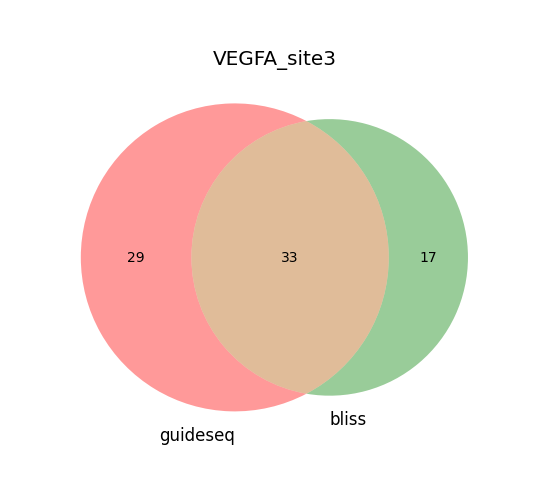

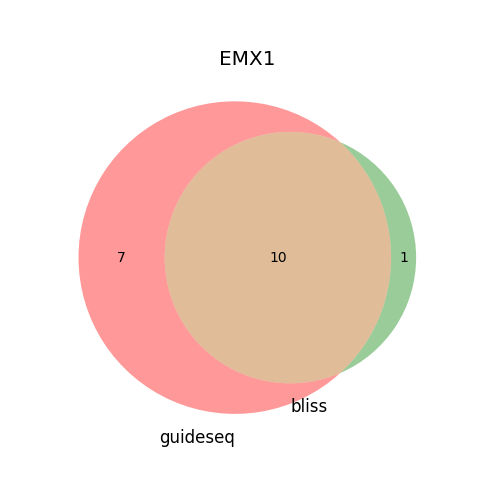

In [20]:
#Ven diagram
from matplotlib_venn import venn2

plt.style.use('ggplot')
for df in dfs_bliss_guideseq_sorted.values():
    #print(df)
    name =df['name'].unique()[0]
    #print(name)
    fig,axs=plt.subplots()    

   


    guideseq_=df[(df['bliss']==0)&(df['guideseq']==1)]
    bliss_=df[(df['bliss']==1)&(df['guideseq']==0)]
 
    both=df[(df['bliss']==1)&(df['guideseq']==1)]
    
             
    v = venn2(subsets=(len(guideseq_),len(bliss_),len(both)), set_labels = ('guideseq','bliss'))
    
    
    plt.title(f"{name}")
    
    
    plt.show()
    

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(fr"plots\BLISS\venn_{name}.png", format='png', dpi=300)

    plt.show()



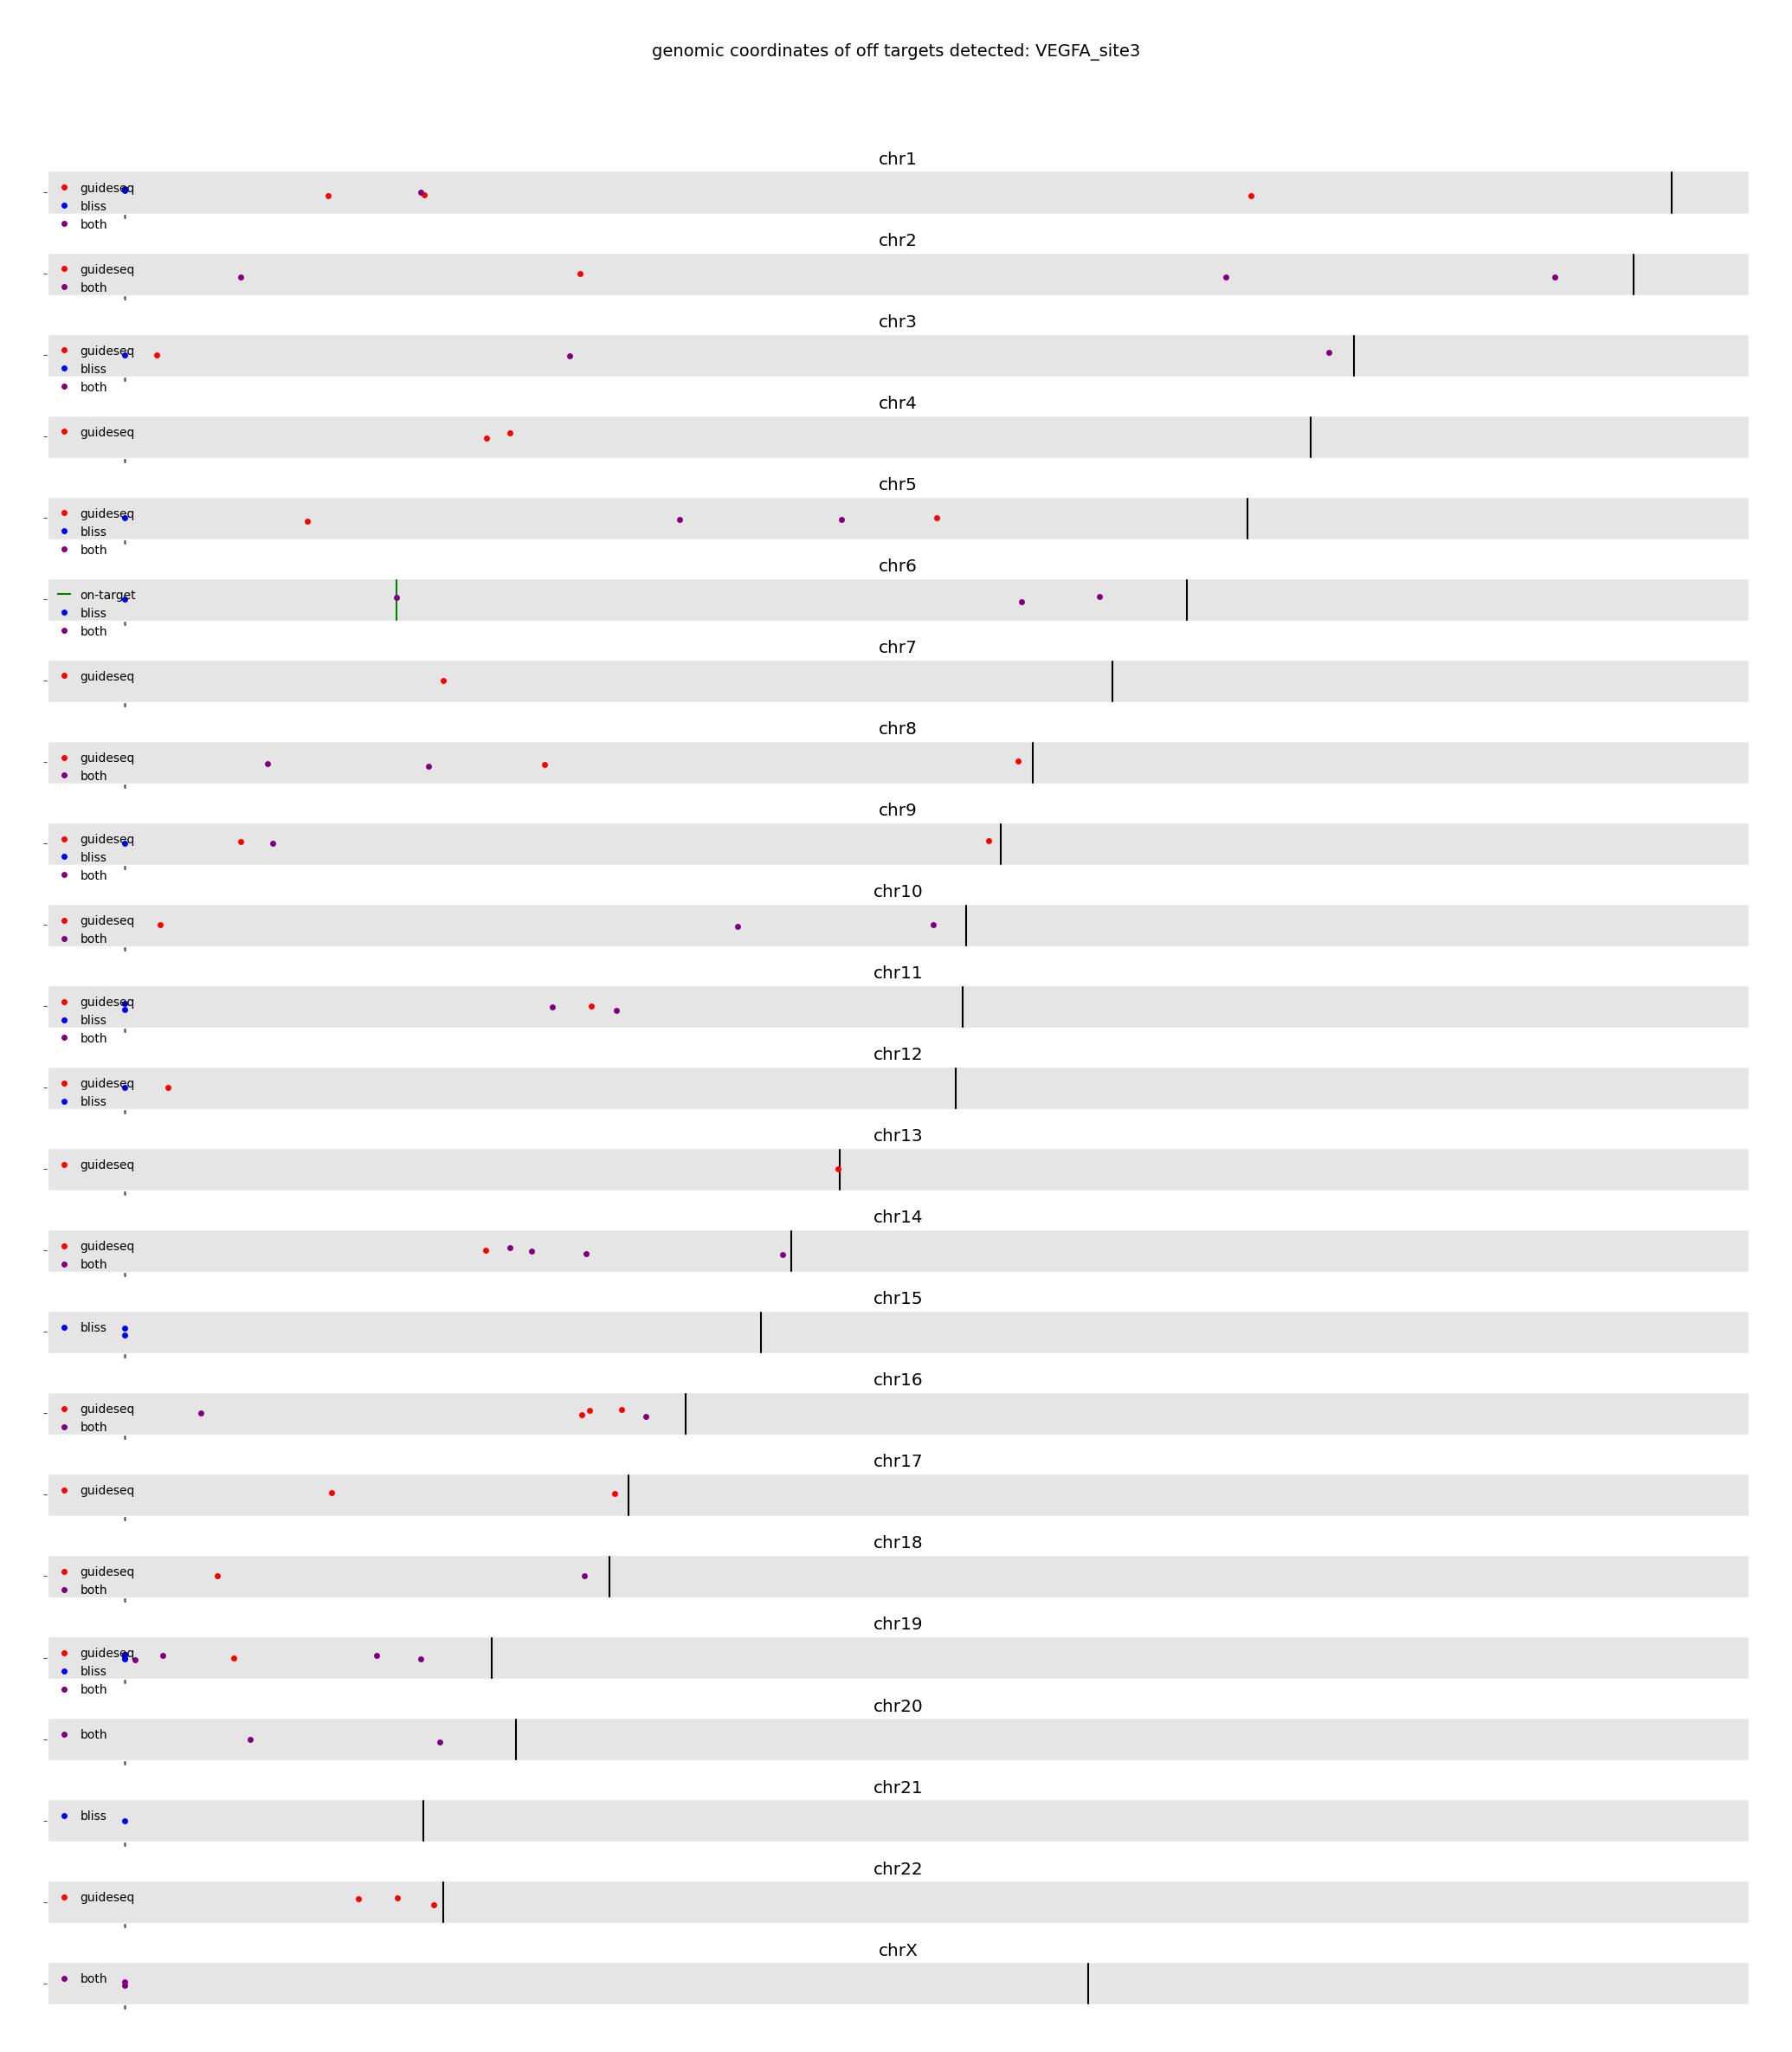

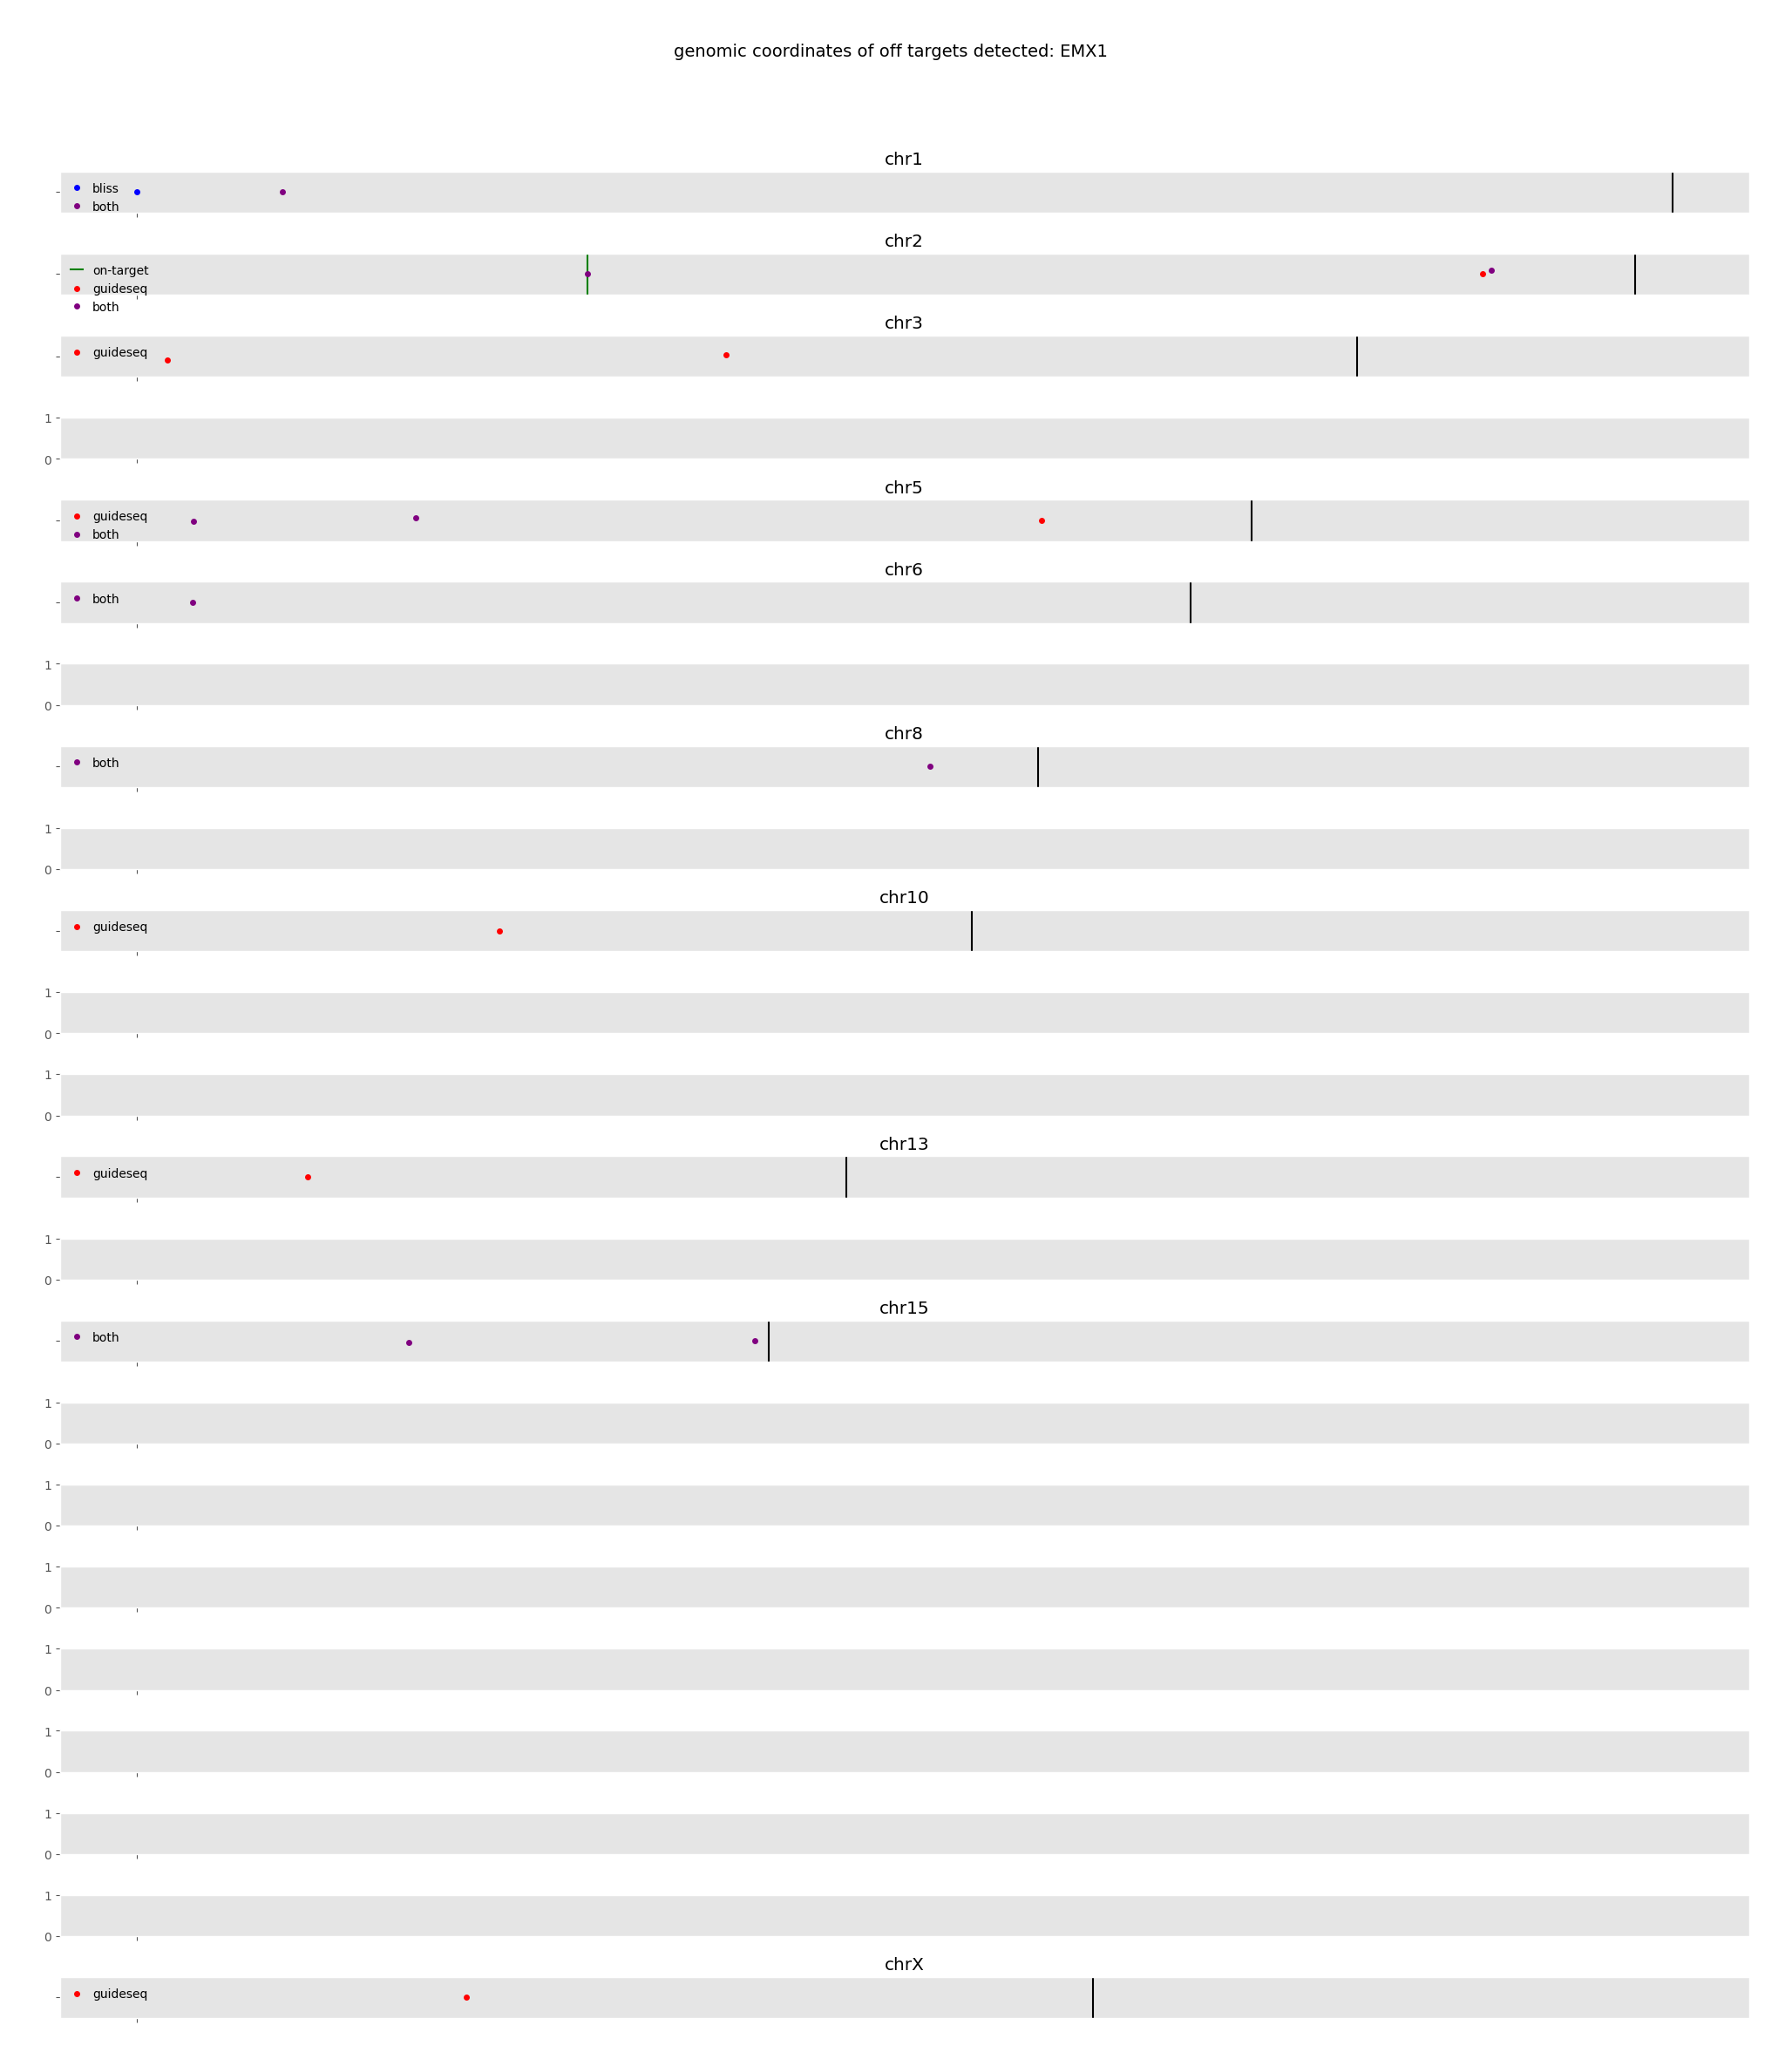

In [21]:
#Stripplot
plt.style.use('ggplot')
for df in dfs_bliss_guideseq_sorted.values():
    #print(df)
    name =df['name'].unique()[0]
    #print(name)
    chroms=df.groupby('chrom')
    fig,axs=plt.subplots(24,1,figsize=(20,25),sharex=True)
    axs=axs.ravel()
    
    target= df[df['mismatch']==0] 
    tchrom= target["chrom"].unique()[0]
    tchromStart=target['chromStart'].unique()[0]
    
    for i in range(23):
        if i==22:
            chrom='chr'+'X'
        else:
            chrom= 'chr'+str(i+1)
        if chrom not in chroms.indices:
            axs[i].xaxis.grid(False)
            continue
        else:
            #print(chrom[0])
            axs[i].xaxis.grid(False)

            #axs[i].set_xlabel('chromStart')
            axs[i].set_title(chrom)
            if chrom==tchrom:
                #rint('y')
                #print(f'ontarget:{tchromStart}')
                #print()
                #print(dfs['PDCD1_site_8']['chromStart'])
                axs[i].axvline(tchromStart,color='green',linestyle='-',label='on-target')
                    
            df=chroms.get_group(chrom)
            guideseq_=df[(df['bliss']==0)&(df['guideseq']==1)]
            bliss_=df[(df['bliss']==1)&(df['guideseq']==0)]
            both=df[(df['bliss']==1)&(df['guideseq']==1)]

            #axs[i].set_xbound(lower=0.0, upper=chromLengths[i])
 
            sns.stripplot(x='chromStart',data=guideseq_,label='guideseq',ax=axs[i],
                            color='red')
            sns.stripplot(x='chromStart',data=bliss_,label='bliss',ax=axs[i],
                          color='blue')
            sns.stripplot(x='chromStart',data=both,label='both',ax=axs[i],
                            color='purple')  

            axs[i].axvline(chromLengths[i],color="black",linestyle="-")

            #plt.xlim(0,chromLengths[i])
    fig.delaxes(axs[23])
    
    fig.suptitle(f'genomic coordinates of off targets detected: {name}',size=14)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(fr"plots\BLISS\{name}.png", format='png', dpi=300)

    plt.show()



### Note
Black line is the end of the chromosome.

## Guide homology score
A score based on the homology was calculated using the Pairwise2 module in the Biopython Python package with the following weights: a match between the sgRNA and the genomic sequence scores +3, a mismatch is −1, whereas an insertion or deletion between the sgRNA and genomic sequence costs −5. Thereby, an on-target sequence with the fully matched 20 bp guide would have a Guide Homology Score of 60. Previously, we included the PAM match in the scoring, yielding a maximum score of 69, but to make the score more versatile and comparable across different PAMs, we removed the PAM dependence in the scoring. Using this guide homology score, we performed a receiver operating characteristic curve analysis based on validated and non-validated off-targets from SpCas9-BLESS10, which justified our previous choice of a homology score cutoff (41 out of a max score of 60), to maximize the sensitivity and specificity of Cas9-BLISS and Cpf1-BLISS. In practical terms, this score corresponds to ≤4 mismatches or ≤2 gaps, as well as combinations thereof.
## DSB score
 number of unique DSB ends aligned to the target per 105 unique BLISS reads